In [1]:
from random import choices, choice, random
from sklearn.metrics.pairwise import cosine_similarity

import lab9_lib
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

# Disclaimer

This is one of the messiest code I have ever written. But also one of the most satisfactory in terms of results. While I say sorry for the way the code is written, I promise to provide more documentation in the near future.

# Methodology

The goal of the Lab is to reach the highest fitness (black box) with the lowest number of evaluations, considering different instances of the problem generated by varying a parameter which can be equal to 1, 2, 5 and 10. All the solutions below have the main goal to reach the highest fitness, even though with more evaluations (which scale polynomially with respect to the marginal increase in fitness once reached a plateau). Acceptable values of fitness can be reached also by lowering the number of evaluations. 

Notice that due to the high randomness, it is quite difficult to give an exact estimate of the number of evaluations, which however can be easily reduced by keeping in memory the fitnesses associated to some individuals or by other means. This is the reason why I mainly focused on increasing the fitness and escaping from plateaus. The number of calls to the fitness can be further greatly reduced by better tuning the hyperparameters, but due to lack of time I leave this as a future improvement.

# Valhalla

##### `make_problem(1)`

- POP_SIZE = 5          
- N_OFFSPRINGS = 10      
- N_GENERATIONS = 250    
- TOP_K = 3              
- EPOCH = 10             
- N_CHAMPIONS = 1        
- SIZE = 1000             
- P_MUTATION = 0.2        
- N_ISLANDS = 1
- N_MIGRANTS = None
- SIZE_VALHALLA = 3 * N_CHAMPIONS
- P_MIGRATION = 0
- P_COMPLETE_MUTATION = 0.01
- COS = None

In [6]:
POP_SIZE = 5                       # Number of parents
N_OFFSPRINGS = 10                   # Number of children
N_GENERATIONS = 300                 # Number of generations
TOP_K = 3                           # Number of parents from which generating the offsprings
EPOCH = 10                          # Number of generation to reintroduce all the champions
N_CHAMPIONS = 1                     # Number of champions that will be picked and sent each time to the population randomly
SIZE = 1000                         # Size of the genome
P_MUTATION = 0.2                    # Probability of a mutation        
N_ISLANDS = 1                       # Number of different populations
N_MIGRANTS = None                   # Number of migrants from one island
SIZE_VALHALLA = 3 * N_CHAMPIONS     # Maximum number of champions
P_MIGRATION = 0
P_COMPLETE_MUTATION = 0.01
COS = None

fitness = lab9_lib.make_problem(1)

globe = {f'island{k}' : {'pop' : []} for k in range(N_ISLANDS)}
family_tree = {}

for n in range(N_ISLANDS):
    for _ in range(POP_SIZE):
        individual = choices([0, 1], k=SIZE, weights=choices(([0.6, 0.4], [0.5, 0.5], [0.4, 0.6]), k = 1)[0])
        globe[f'island{n}']['pop'].append(individual)

In [7]:
def mutate_bit(individual : list) -> list:
    if random() < P_MUTATION:    
        idx = np.random.randint(0, len(individual))
        mutated_individual = copy.deepcopy(individual)
        mutated_individual[idx] = 1 - mutated_individual[idx]
        return mutated_individual
    return individual


def get_distribution(survived : list) -> list:
    return (np.sum(survived, axis = 0) / (np.ones(shape = len(survived[0])) * POP_SIZE)).reshape(1, -1)


def compute_cosine(individual : list, distr : list) -> list:
    return cosine_similarity(np.array(individual).reshape(1, -1), distr.reshape(1, -1))


def compute_manhattan(individual : list, distr : list) -> list:
    return np.sum(np.abs(np.array(individual) - distr))


def mutate_all(individual : list) -> list:
    mutated_individual = copy.deepcopy(individual)
    for idx in range(len(mutated_individual)):
        if random() < P_COMPLETE_MUTATION:
            mutated_individual[idx] = 1 - mutated_individual[idx]
    return mutated_individual


def roulette_selection(top_k : int, individuals : list, fitness : list) -> list:
    parents = choices(individuals, weights=np.array(fitness)/sum(fitness), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def roulette_selection_memoization(top_k : int, individuals : list, family_tree) -> list:
    fitness_list = []
    for individual in individuals:
        fitness_list.append(family_tree[tuple(individual)])
    
    parents = choices(individuals, weights=np.array(fitness_list)/sum(fitness_list), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def one_cut_xover(couple : tuple) -> list:
    idx = np.random.randint(1, len(couple[0]) - 1)
    return np.concatenate((couple[0][:idx], couple[1][idx:]))

def uniform_xover(couple : tuple) -> list:
    child = np.ndarray(shape = len(couple[0]), dtype=np.int16)
    for i in range(len(couple[0])):
        gene_giver = choice([couple[0], couple[1]])
        child[i] = int(gene_giver[i])
    return child

def n_cuts_xover(couple : tuple) -> list:
    if random() < 0.7:
        idx_1 = np.random.randint(1, len(couple[0]) - 2)
        idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
        return np.concatenate((couple[0][idx_1:idx_2], couple[1][:idx_1], couple[0][idx_2:]))
    else:
        idx_1 = np.random.randint(1, len(couple[0]) / 2)
        idx_3 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
        idx_2 = np.random.randint(idx_1, idx_3)
        return np.concatenate((couple[1][:idx_1], couple[0][idx_1:idx_2], couple[1][idx_2:idx_3], couple[0][idx_3:]))

def random_xover(couple : tuple) -> list:
    flag = random()
    if flag < 0.33:
        return one_cut_xover(couple)
    elif 0.33 <= flag < 0.66:
        return uniform_xover(couple)
    elif 0.66 <= flag < 1:
        return n_cuts_xover(couple)

In [8]:
for island in globe.keys():
    family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['pop']})
    globe[island]['parents'] = roulette_selection_memoization(TOP_K, globe[island]['pop'], family_tree)
    globe[island]['valhalla'] = np.zeros(shape = (SIZE_VALHALLA, SIZE), dtype=np.int16)
    globe[island]['max_fit'] = []
    globe[island]['avg_fit'] = []
    globe[island]['fit_god'] = 0
    globe[island]['migration'] = []

terminator = False
gen = 0
end = 0
pbar = tqdm(total = N_GENERATIONS)

while gen < N_GENERATIONS and not terminator:

    for island in globe.keys():
        if random() < P_MIGRATION and len(globe.keys()) > 1:
             
             if np.array(['survived' in globe[isl].keys() for isl in globe.keys()]).all():
                # Compute the distribution of each island
                island_distr = {isl : get_distribution(globe[isl]['survived']) for isl in globe.keys()}
                # Compute the cosine similarity between distributions
                if COS:
                    island_cos = {isl : cosine_similarity(island_distr[isl], get_distribution(globe[island]['survived'])) for isl in island_distr.keys()}
                    unnormalized_weights = 1 / np.array(list(island_cos.values()))
                    weights = unnormalized_weights / sum(unnormalized_weights)
                else:
                    island_manhattan = {isl : compute_manhattan(island_distr[isl], get_distribution(globe[island]['survived'])) for isl in island_distr.keys()}
                    weights = (np.array(list(island_manhattan.values())) ** 2) / (sum(np.array(list(island_manhattan.values())) ** 2))
                
                       
                home = choices([isl for isl in globe.keys()], weights=weights)[0]
                # home = choice([isl for isl in globe.keys() if isl != island])
                if 'valhalla' in globe[home].keys() and len(globe[home]['valhalla']) != 0:
                    migrant = list(map(list, choices(globe[home]['valhalla'], k = N_MIGRANTS)))
                    migrant_couple = [(migrant[i], globe[island]['parents'][rnd][0]) for i, rnd in zip(range(len(migrant)), np.random.randint(0, len(globe[island]['parents']), size = len(migrant)))]
                    globe[island]['parents'] = globe[island]['parents'] + migrant_couple
                    globe[island]['migration'].append(True)
        else:
            globe[island]['migration'].append(False)

        recombinated_offsprings = list(map(random_xover, globe[island]['parents']))
        globe[island]['mutated_offsprings'] = np.array(list(map(mutate_bit, recombinated_offsprings)))
        if random() < 0.1:
            zombie = []
            sur = globe[island]['mutated_offsprings']
            for s in sur:
                if random() < 0.2:
                    zombie.append(mutate_all(s))
            if len(zombie) != 0:
                globe[island]['mutated_offsprings'] = np.vstack((globe[island]['mutated_offsprings'], zombie))
                                   
        fitness_list = []

        for off in globe[island]['mutated_offsprings']:
            if tuple(off) not in family_tree.keys():
                family_tree[tuple(off)] = fitness(tuple(off))
            fitness_list.append(family_tree[tuple(off)])

        globe[island]['fit'] = np.array(fitness_list)
        globe[island]['survived'] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-POP_SIZE:]]
        globe[island]['max_fit'].append(max(globe[island]['fit']))
        god = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-1]]
        fitness_god = fitness(god)
        if fitness_god >= globe[island]['fit_god']:
            globe[island]['god'] = god
            globe[island]['fit_god'] = fitness_god

        globe[island]['avg_fit'].append(np.mean(globe[island]['fit']))
        
        if globe[island]['fit_god'] == 1.00:
            terminator = True
            break
        
        # Every 10 generations, pick the champions and put them in a buffer, which, once full
        # (size equal to 3 * N_CHAMPIONS) keeps the most recent 2 * N_CHAMPIONS and substitutes
        # the oldest 1 * N_CHAMPIONS with the ones just computed.
        if gen % 10 == 0 and gen != 0:
            if end == 0 or end == SIZE_VALHALLA:
                count = 0
            start = count
            end = start + N_CHAMPIONS
            count += N_CHAMPIONS
            globe[island]['valhalla'][start:end, :] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-N_CHAMPIONS:]]
        
        # Every epoch, load the valhalla and compute the parents.
        if gen % EPOCH == 0 and gen != 0:
            globe[island]['survived'] = np.concatenate((globe[island]['survived'], globe[island]['valhalla']))

        # Introduce some randomicity in order to inject champions from time to time.
        if random() < 0.5  and gen != 0:
            globe[island]['survived'] = np.concatenate((globe[island]['survived'], choices(globe[island]['valhalla'], k = N_CHAMPIONS)))
        
        if random() < 0.1:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], globe[island]['god']))

        family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['survived']})
        globe[island]['parents'] = roulette_selection_memoization(TOP_K, globe[island]['survived'], family_tree)
        
    gen += 1
    pbar.update(1)
    
pbar.close()
fit_island = {globe[i]['fit_god'] : i for i in globe.keys()}
print(f'Fitness calls: {fitness.calls}\nMax fitness: {max(fit_island.keys())} ({fit_island[max(fit_island.keys())]})')

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:01<00:00, 229.81it/s]

Fitness calls: 2442
Max fitness: 0.998 (island0)


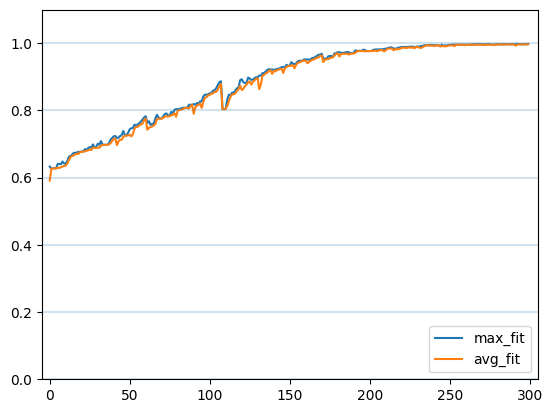

In [12]:
for isl in globe.keys():
    plt.plot(globe[isl]['max_fit'], label = 'max_fit')
    plt.plot(globe[isl]['avg_fit'], label = 'avg_fit')
    
plt.xlim(-5, gen + 5)
plt.ylim(0, 1 + 0.1)
_ = [plt.axhline(y = height, alpha = 0.2) for height in np.linspace(0, 1.0, 6)]

plt.legend(loc = 'lower right')

In [13]:
mutated_fitness = list(map(fitness, globe['island0']['valhalla']))
ordered_mutated = [_ for _, x in sorted(zip(globe['island0']['valhalla'], mutated_fitness), key=lambda pair: pair[1], reverse=True)]

for sur in ordered_mutated:
    print(f"{''.join(str(g) for g in sur)}: {fitness(sur):.2%}")
print()
print(f"{''.join(str(g) for g in globe['island0']['god'])}: {globe['island0']['fit_god']:.2%}")

1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111100111

# Valhalla + Islands

##### `make_problem(2)`

- POP_SIZE = 5          
- N_OFFSPRINGS = 40      
- N_GENERATIONS = 1000    
- TOP_K = 2              
- EPOCH = 3             
- N_CHAMPIONS = 1        
- SIZE = 1000             
- P_MUTATION = 0.2        
- N_ISLANDS = 15
- N_MIGRANTS = 1
- SIZE_VALHALLA = 3 * N_CHAMPIONS
- P_MIGRATION = 0.1
- P_COMPLETE_MUTATION = 0.2
- COS = False

In [14]:
POP_SIZE = 5                        # Number of parents
N_OFFSPRINGS = 40                   # Number of children
N_GENERATIONS = 1000                # Number of generations
TOP_K = 2                           # Number of parents from which generating the offsprings
EPOCH = 3                           # Number of generation to reintroduce all the champions
N_CHAMPIONS = 1                     # Number of champions that will be picked and sent each time to the population randomly
SIZE = 1000                         # Size of the genome
P_MUTATION = 0.2                    # Probability of a mutation        
N_ISLANDS = 15                      # Number of different populations
N_MIGRANTS = 1                      # Number of migrants from one island
SIZE_VALHALLA = 3 * N_CHAMPIONS     # Maximum number of champions
P_MIGRATION = 0.1
P_COMPLETE_MUTATION = 0.2
COS = False

fitness = lab9_lib.make_problem(2)

globe = {f'island{k}' : {'pop' : []} for k in range(N_ISLANDS)}
family_tree = {}

for n in range(N_ISLANDS):
    for _ in range(POP_SIZE):
        individual = choices([0, 1], k=SIZE, weights=choices(([0.6, 0.4], [0.5, 0.5], [0.4, 0.6]), k = 1)[0])
        globe[f'island{n}']['pop'].append(individual)

In [15]:
def mutate_bit(individual : list) -> list:
    if random() < P_MUTATION:    
        idx = np.random.randint(0, len(individual))
        mutated_individual = copy.deepcopy(individual)
        mutated_individual[idx] = 1 - mutated_individual[idx]
        return mutated_individual
    return individual


def get_distribution(survived : list) -> list:
    return (np.sum(survived, axis = 0) / (np.ones(shape = len(survived[0])) * POP_SIZE)).reshape(1, -1)


def compute_cosine(individual : list, distr : list) -> list:
    return cosine_similarity(np.array(individual).reshape(1, -1), distr.reshape(1, -1))


def compute_manhattan(individual : list, distr : list) -> list:
    return np.sum(np.abs(np.array(individual) - distr))


def mutate_all(individual : list) -> list:
    mutated_individual = copy.deepcopy(individual)
    for idx in range(len(mutated_individual)):
        if random() < P_COMPLETE_MUTATION:
            mutated_individual[idx] = 1 - mutated_individual[idx]
    return mutated_individual


def roulette_selection(top_k : int, individuals : list, fitness : list) -> list:
    parents = choices(individuals, weights=np.array(fitness)/sum(fitness), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def roulette_selection_memoization(top_k : int, individuals : list, family_tree) -> list:
    fitness_list = []
    for individual in individuals:
        fitness_list.append(family_tree[tuple(individual)])
    
    parents = choices(individuals, weights=np.array(fitness_list)/sum(fitness_list), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def one_cut_xover(couple : tuple) -> list:
    idx = np.random.randint(1, len(couple[0]) - 1)
    return np.concatenate((couple[0][:idx], couple[1][idx:]))

def uniform_xover(couple : tuple) -> list:
    child = np.ndarray(shape = len(couple[0]), dtype=np.int16)
    for i in range(len(couple[0])):
        gene_giver = choice([couple[0], couple[1]])
        child[i] = int(gene_giver[i])
    return child

def n_cuts_xover(couple : tuple) -> list:
    if random() < 0.7:
        idx_1 = np.random.randint(1, len(couple[0]) - 2)
        idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
        return np.concatenate((couple[0][idx_1:idx_2], couple[1][:idx_1], couple[0][idx_2:]))
    else:
        idx_1 = np.random.randint(1, len(couple[0]) / 2)
        idx_3 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
        idx_2 = np.random.randint(idx_1, idx_3)
        return np.concatenate((couple[1][:idx_1], couple[0][idx_1:idx_2], couple[1][idx_2:idx_3], couple[0][idx_3:]))

def random_xover(couple : tuple) -> list:
    flag = random()
    if flag < 0.33:
        return one_cut_xover(couple)
    elif 0.33 <= flag < 0.66:
        return uniform_xover(couple)
    elif 0.66 <= flag < 1:
        return n_cuts_xover(couple)

In [16]:
for island in globe.keys():
    family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['pop']})
    globe[island]['parents'] = roulette_selection_memoization(TOP_K, globe[island]['pop'], family_tree)
    globe[island]['valhalla'] = np.zeros(shape = (SIZE_VALHALLA, SIZE), dtype=np.int16)
    globe[island]['max_fit'] = []
    globe[island]['avg_fit'] = []
    globe[island]['fit_god'] = 0
    globe[island]['migration'] = []

terminator = False
gen = 0
end = 0
pbar = tqdm(total = N_GENERATIONS)

while gen < N_GENERATIONS and not terminator:

    for island in globe.keys():

        if random() < P_MIGRATION and len(globe.keys()) > 1:
             
             if np.array(['survived' in globe[isl].keys() for isl in globe.keys()]).all():
                island_distr = {isl : get_distribution(globe[isl]['survived']) for isl in globe.keys()}
    
                if COS:
                    island_cos = {isl : cosine_similarity(island_distr[isl], get_distribution(globe[island]['survived'])) for isl in island_distr.keys()}
                    unnormalized_weights = 1 / np.array(list(island_cos.values()))
                    weights = unnormalized_weights / sum(unnormalized_weights)
                else:
                    island_manhattan = {isl : compute_manhattan(island_distr[isl], get_distribution(globe[island]['survived'])) for isl in island_distr.keys()}
                    weights = (np.array(list(island_manhattan.values())) ** 2) / (sum(np.array(list(island_manhattan.values())) ** 2))
                
                       
                home = choices([isl for isl in globe.keys()], weights=weights)[0]
                # home = choice([isl for isl in globe.keys() if isl != island])
                if 'valhalla' in globe[home].keys() and len(globe[home]['valhalla']) != 0:
                    migrant = list(map(list, choices(globe[home]['valhalla'], k = N_MIGRANTS)))
                    migrant_couple = [(migrant[i], globe[island]['parents'][rnd][0]) for i, rnd in zip(range(len(migrant)), np.random.randint(0, len(globe[island]['parents']), size = len(migrant)))]
                    globe[island]['parents'] = globe[island]['parents'] + migrant_couple
                    globe[island]['migration'].append(True)
        else:
            globe[island]['migration'].append(False)

        recombinated_offsprings = list(map(random_xover, globe[island]['parents']))
        globe[island]['mutated_offsprings'] = np.array(list(map(mutate_bit, recombinated_offsprings)))
        if random() < 0.1:
            zombie = []
            sur = globe[island]['mutated_offsprings']
            for s in sur:
                if random() < 0.2:
                    zombie.append(mutate_all(s))
            if len(zombie) != 0:
                globe[island]['mutated_offsprings'] = np.vstack((globe[island]['mutated_offsprings'], zombie))
                                   
        fitness_list = []

        for off in globe[island]['mutated_offsprings']:
            if tuple(off) not in family_tree.keys():
                family_tree[tuple(off)] = fitness(tuple(off))
            fitness_list.append(family_tree[tuple(off)])

        globe[island]['fit'] = np.array(fitness_list)
        globe[island]['survived'] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-POP_SIZE:]]
        globe[island]['max_fit'].append(max(globe[island]['fit']))
        god = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-1]]
        fitness_god = fitness(god)
        if fitness_god >= globe[island]['fit_god']:
            globe[island]['god'] = god
            globe[island]['fit_god'] = fitness_god

        globe[island]['avg_fit'].append(np.mean(globe[island]['fit']))
        
        if globe[island]['fit_god'] >= 0.996:
            terminator = True
            break
    
        if gen % 10 == 0 and gen != 0:
            if end == 0 or end == SIZE_VALHALLA:
                count = 0
            start = count
            end = start + N_CHAMPIONS
            count += N_CHAMPIONS
            globe[island]['valhalla'][start:end, :] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-N_CHAMPIONS:]]
        
        if gen % EPOCH == 0 and gen != 0:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], globe[island]['valhalla']))

        if random() < 0.5  and gen != 0:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], choices(globe[island]['valhalla'], k = N_CHAMPIONS)))
        
        if random() < 0.1:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], globe[island]['god']))

        family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['survived']})
        globe[island]['parents'] = roulette_selection_memoization(TOP_K, globe[island]['survived'], family_tree)
        
    gen += 1

    pbar.update(1)

pbar.close()
fit_island = {globe[i]['fit_god'] : i for i in globe.keys()}
print(f'Fitness calls: {fitness.calls}\nMax fitness: {max(fit_island.keys())} ({fit_island[max(fit_island.keys())]})')

  0%|          | 0/1000 [00:00<?, ?it/s]

 54%|█████▍    | 542/1000 [01:54<01:36,  4.73it/s]

Fitness calls: 207538
Max fitness: 0.996 (island8)


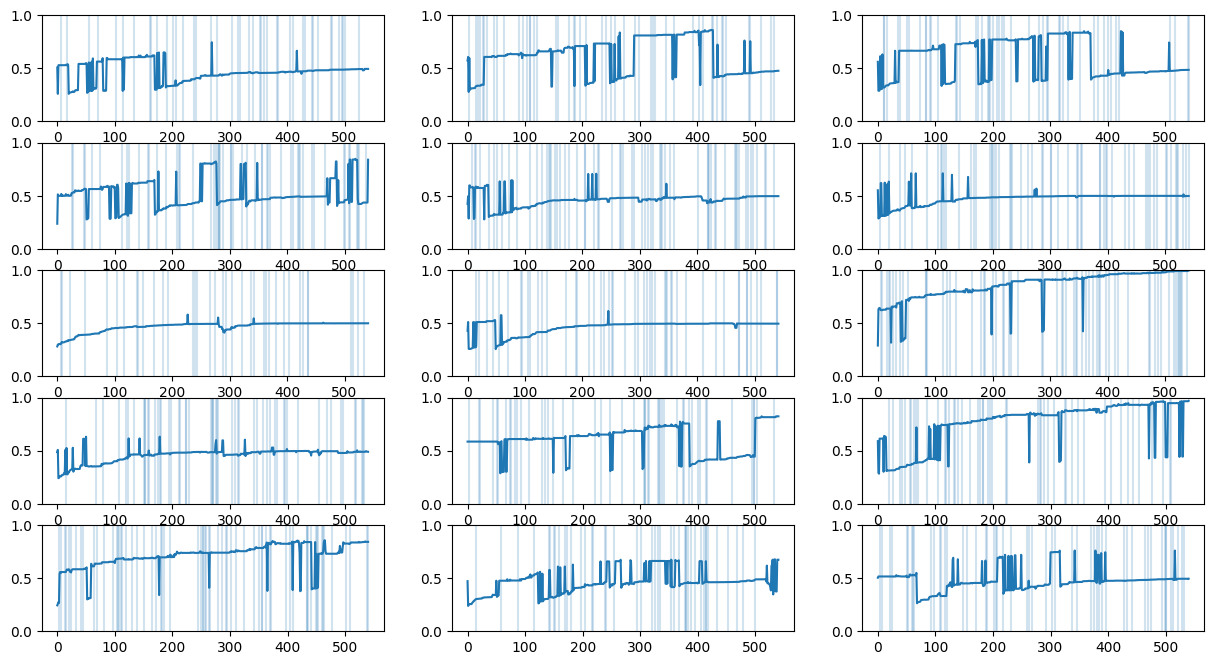

In [17]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize = (15, 8))

ax[0, 0].plot(globe['island0']['max_fit'])
[ax[0, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island0']['migration'][idx] is True else 0 for idx in range(len(globe['island0']['migration']))] if element != 0]]
ax[0, 0].set_ylim(0, 1)

ax[0, 1].plot(globe['island1']['max_fit'])
[ax[0, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island1']['migration'][idx] is True else 0 for idx in range(len(globe['island1']['migration']))] if element != 0]]
ax[0, 1].set_ylim(0, 1)

ax[0, 2].plot(globe['island2']['max_fit'])
[ax[0, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island2']['migration'][idx] is True else 0 for idx in range(len(globe['island2']['migration']))] if element != 0]]
ax[0, 2].set_ylim(0, 1)

ax[1, 0].plot(globe['island3']['max_fit'])
[ax[1, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island3']['migration'][idx] is True else 0 for idx in range(len(globe['island3']['migration']))] if element != 0]]
ax[1, 0].set_ylim(0, 1)

ax[1, 1].plot(globe['island4']['max_fit'])
[ax[1, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island4']['migration'][idx] is True else 0 for idx in range(len(globe['island4']['migration']))] if element != 0]]
ax[1, 1].set_ylim(0, 1)

ax[1, 2].plot(globe['island5']['max_fit'])
[ax[1, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island5']['migration'][idx] is True else 0 for idx in range(len(globe['island5']['migration']))] if element != 0]]
ax[1, 2].set_ylim(0, 1)

ax[2, 0].plot(globe['island6']['max_fit'])
[ax[2, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island6']['migration'][idx] is True else 0 for idx in range(len(globe['island6']['migration']))] if element != 0]]
ax[2, 0].set_ylim(0, 1)

ax[2, 1].plot(globe['island7']['max_fit'])
[ax[2, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island7']['migration'][idx] is True else 0 for idx in range(len(globe['island7']['migration']))] if element != 0]]
ax[2, 1].set_ylim(0, 1)

ax[2, 2].plot(globe['island8']['max_fit'])
[ax[2, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island8']['migration'][idx] is True else 0 for idx in range(len(globe['island8']['migration']))] if element != 0]]
ax[2, 2].set_ylim(0, 1)

ax[3, 0].plot(globe['island9']['max_fit'])
[ax[3, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island9']['migration'][idx] is True else 0 for idx in range(len(globe['island9']['migration']))] if element != 0]]
ax[3, 0].set_ylim(0, 1)

ax[3, 1].plot(globe['island10']['max_fit'])
[ax[3, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island10']['migration'][idx] is True else 0 for idx in range(len(globe['island10']['migration']))] if element != 0]]
ax[3, 1].set_ylim(0, 1)

ax[3, 2].plot(globe['island11']['max_fit'])
[ax[3, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island11']['migration'][idx] is True else 0 for idx in range(len(globe['island11']['migration']))] if element != 0]]
ax[3, 2].set_ylim(0, 1)

ax[4, 0].plot(globe['island12']['max_fit'])
[ax[4, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island12']['migration'][idx] is True else 0 for idx in range(len(globe['island12']['migration']))] if element != 0]]
ax[4, 0].set_ylim(0, 1)

ax[4, 1].plot(globe['island13']['max_fit'])
[ax[4, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island13']['migration'][idx] is True else 0 for idx in range(len(globe['island13']['migration']))] if element != 0]]
ax[4, 1].set_ylim(0, 1)

ax[4, 2].plot(globe['island14']['max_fit'])
[ax[4, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island14']['migration'][idx] is True else 0 for idx in range(len(globe['island14']['migration']))] if element != 0]]
_ = ax[4, 2].set_ylim(0, 1)


# Valhalla + Islands + Federation (Independent Federation)

##### `make_problem(5)`

- POP_SIZE = 30          
- N_OFFSPRINGS = 60      
- N_GENERATIONS = 2000    
- TOP_K = 15              
- EPOCH = 5             
- N_CHAMPIONS = 4        
- SIZE = 1000             
- P_MUTATION = 0.2        
- N_ISLANDS = 40
- N_MIGRANTS = 4
- SIZE_VALHALLA = 3 * N_CHAMPIONS
- P_MIGRATION = 0.2
- P_COMPLETE_MUTATION = 0.2
- COS = False
- GEN_TO_HOLIDAY = 10
- MIGRANTS_TO_HOLIDAY = 5
- HOLIDAY_DAYS = 50
- EPOCH_DUBAI = 20
- N_CHAMPIONS_DUBAI = 3
- SIZE_VALHALLA_DUBAI = 5 * N_CHAMPIONS_DUBAI

In [2]:
# Reached 0.745 with more or less 300_000 calls with the following configuration!!!
POP_SIZE = 30                        # Number of parents
N_OFFSPRINGS = 60                   # Number of children
N_GENERATIONS = 300                # Number of generations
TOP_K = 15                           # Number of parents from which generating the offsprings
EPOCH = 5                           # Number of generation to reintroduce all the champions
N_CHAMPIONS = 4                     # Number of champions that will be picked and sent each time to the population randomly
SIZE = 1000                         # Size of the genome
P_MUTATION = 0.2                    # Probability of a mutation        
N_ISLANDS = 40                      # Number of different populations
N_MIGRANTS = 4                      # Number of migrants from one island
SIZE_VALHALLA = 3 * N_CHAMPIONS     # Maximum number of champions
P_MIGRATION = 0.2
P_COMPLETE_MUTATION = 0.2
COS = False
GEN_TO_HOLIDAY = 10
MIGRANTS_TO_HOLIDAY = 5
HOLIDAY_DAYS = 50
EPOCH_DUBAI = 20
N_CHAMPIONS_DUBAI = 3
SIZE_VALHALLA_DUBAI = 5 * N_CHAMPIONS_DUBAI

fitness = lab9_lib.make_problem(5)

globe = {f'island{k}' : {'pop' : []} for k in range(N_ISLANDS)}
family_tree = {}

for n in range(N_ISLANDS):
    for _ in range(POP_SIZE):
        individual = choices([0, 1], k=SIZE, weights=choices(([0.6, 0.4], [0.5, 0.5], [0.4, 0.6]), k = 1)[0])
        globe[f'island{n}']['pop'].append(individual)

In [3]:
def mutate_bit(individual : list) -> list:
    if random() < P_MUTATION:    
        idx = np.random.randint(0, len(individual))
        mutated_individual = copy.deepcopy(individual)
        mutated_individual[idx] = 1 - mutated_individual[idx]
        return mutated_individual
    return individual


def get_distribution(survived : list) -> list:
    return (np.sum(survived, axis = 0) / (np.ones(shape = len(survived[0])) * POP_SIZE)).reshape(1, -1)


def compute_cosine(individual : list, distr : list) -> list:
    return cosine_similarity(np.array(individual).reshape(1, -1), distr.reshape(1, -1))


def compute_manhattan(individual : list, distr : list) -> list:
    return np.sum(np.abs(np.array(individual) - distr))


def mutate_all(individual : list) -> list:
    mutated_individual = copy.deepcopy(individual)
    for idx in range(len(mutated_individual)):
        if random() < P_COMPLETE_MUTATION:
            mutated_individual[idx] = 1 - mutated_individual[idx]
    return mutated_individual


def roulette_selection(top_k : int, individuals : list, fitness : list) -> list:
    parents = choices(individuals, weights=np.array(fitness)/sum(fitness), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def roulette_selection_memoization(top_k : int, individuals : list, family_tree, dubai : bool = False) -> list:
    fitness_list = []
    for individual in individuals:
         
        if tuple(individual) not in family_tree.keys():
            family_tree[tuple(individual)] = fitness(individual)
            fitness_list.append(family_tree[tuple(individual)])
        else:
            fitness_list.append(family_tree[tuple(individual)])
        
    parents = choices(individuals, weights=np.array(fitness_list)/sum(fitness_list), k=top_k)
    if dubai:
        return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=300)
    
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def one_cut_xover(couple : tuple) -> list:
    idx = np.random.randint(1, len(couple[0]) - 1)
    return np.concatenate((couple[0][:idx], couple[1][idx:]))

def uniform_xover(couple : tuple) -> list:
    child = np.ndarray(shape = len(couple[0]), dtype=np.int16)
    for i in range(len(couple[0])):
        gene_giver = choice([couple[0], couple[1]])
        child[i] = int(gene_giver[i])
    return child

def n_cuts_xover(couple : tuple) -> list:
    if random() < 0.7:
        idx_1 = np.random.randint(1, len(couple[0]) - 2)
        idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
        return np.concatenate((couple[0][idx_1:idx_2], couple[1][:idx_1], couple[0][idx_2:]))
    else:
        idx_1 = np.random.randint(1, len(couple[0]) / 2)
        idx_3 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
        idx_2 = np.random.randint(idx_1, idx_3)
        return np.concatenate((couple[1][:idx_1], couple[0][idx_1:idx_2], couple[1][idx_2:idx_3], couple[0][idx_3:]))

def random_xover(couple : tuple) -> list:
    flag = random()
    if flag < 0.33:
        return one_cut_xover(couple)
    elif 0.33 <= flag < 0.66:
        return uniform_xover(couple)
    elif 0.66 <= flag < 1:
        return n_cuts_xover(couple)

In [4]:
dubai = {}
dubai['max_fit'] = []
dubai['avg_fit'] = []
dubai['valhalla'] = np.zeros(shape = (SIZE_VALHALLA_DUBAI, SIZE), dtype=np.int16)
dubai['fit_god'] = 0
dubai['survived'] = np.zeros(shape = 1000)

for island in globe.keys():
    family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['pop']})
    globe[island]['parents'] = roulette_selection_memoization(TOP_K, globe[island]['pop'], family_tree)
    globe[island]['valhalla'] = np.zeros(shape = (SIZE_VALHALLA, SIZE), dtype=np.int16)
    globe[island]['max_fit'] = []
    globe[island]['avg_fit'] = []
    globe[island]['fit_god'] = 0
    globe[island]['migration'] = []


terminator = False
gen = 0
end = 0
end_dubai = 0
pbar = tqdm(total = N_GENERATIONS)

while gen < N_GENERATIONS and not terminator:
    
    for island in globe.keys():

        if random() < P_MIGRATION and len(globe.keys()) > 1:
             
             if np.array(['survived' in globe[isl].keys() for isl in globe.keys()]).all():
                island_distr = {isl : get_distribution(globe[isl]['survived']) for isl in globe.keys()}
    
                if COS:
                    island_cos = {isl : cosine_similarity(island_distr[isl], get_distribution(globe[island]['survived'])) for isl in island_distr.keys()}
                    unnormalized_weights = 1 / np.array(list(island_cos.values()))
                    weights = unnormalized_weights / sum(unnormalized_weights)
                else:
                    island_manhattan = {isl : compute_manhattan(island_distr[isl], get_distribution(globe[island]['survived'])) for isl in island_distr.keys()}
                    weights = (np.array(list(island_manhattan.values())) ** 2) / (sum(np.array(list(island_manhattan.values())) ** 2))
                
                       
                home = choices([isl for isl in globe.keys()], weights=weights)[0]
                # home = choice([isl for isl in globe.keys() if isl != island])
                if 'valhalla' in globe[home].keys() and len(globe[home]['valhalla']) != 0:
                    migrant = list(map(list, choices(globe[home]['valhalla'], k = N_MIGRANTS)))
                    migrant_couple = [(migrant[i], globe[island]['parents'][rnd][0]) for i, rnd in zip(range(len(migrant)), np.random.randint(0, len(globe[island]['parents']), size = len(migrant)))]
                    globe[island]['parents'] = globe[island]['parents'] + migrant_couple
                    globe[island]['migration'].append(True)
        else:
            globe[island]['migration'].append(False)

        recombinated_offsprings = list(map(random_xover, globe[island]['parents']))
        globe[island]['mutated_offsprings'] = np.array(list(map(mutate_bit, recombinated_offsprings)))
        if random() < 0.1:
            zombie = []
            sur = globe[island]['mutated_offsprings']
            for s in sur:
                if random() < 0.2:
                    zombie.append(mutate_all(s))
            if len(zombie) != 0:
                globe[island]['mutated_offsprings'] = np.vstack((globe[island]['mutated_offsprings'], zombie))
                                   
        fitness_list = []

        for off in globe[island]['mutated_offsprings']:
            if tuple(off) not in family_tree.keys():
                family_tree[tuple(off)] = fitness(tuple(off))
            fitness_list.append(family_tree[tuple(off)])

        globe[island]['fit'] = np.array(fitness_list)
        globe[island]['survived'] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-POP_SIZE:]]
        globe[island]['max_fit'].append(max(globe[island]['fit']))
        god = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-1]]
        fitness_god = fitness(god) if tuple(god) not in family_tree.keys() else family_tree[tuple(god)]
        if fitness_god >= globe[island]['fit_god']:
            globe[island]['god'] = god
            globe[island]['fit_god'] = fitness_god
        
        globe[island]['avg_fit'].append(np.mean(globe[island]['fit']))
        
        if globe[island]['fit_god'] >= 0.70:
            terminator = True
            break
    
        if gen % 10 == 0 and gen != 0:
            if end == 0 or end == SIZE_VALHALLA:
                count = 0
            start = count
            end = start + N_CHAMPIONS
            count += N_CHAMPIONS
            globe[island]['valhalla'][start:end, :] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-N_CHAMPIONS:]]
        
        if gen % EPOCH == 0 and gen != 0:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], globe[island]['valhalla']))

        if random() < 0.5  and gen != 0:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], choices(globe[island]['valhalla'], k = N_CHAMPIONS)))
        
        if random() < 0.1:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], globe[island]['god']))

        family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['survived']})

    gen += 1
    if gen % GEN_TO_HOLIDAY == 0:
            tmp = [choices(globe[isl]['survived'], k = MIGRANTS_TO_HOLIDAY) for isl in globe.keys()]
            tmp_2 = [globe[isl]['god'] for isl in globe.keys()]
            for i, b in zip(tmp, tmp_2):
                for a in i:
                    dubai['survived'] = np.vstack((dubai['survived'], np.array(a)))
                dubai['survived'] = np.vstack((dubai['survived'], np.array(b)))
            dubai['parents'] = roulette_selection_memoization(30, dubai['survived'], family_tree, True)

            for _ in range(HOLIDAY_DAYS):
    
                recombinated_offsprings = list(map(random_xover, dubai['parents']))
                dubai['mutated_offsprings'] = np.array(list(map(mutate_bit, recombinated_offsprings)))
                
                if random() < 0.1:
                    zombie_dubai = []
                    sur_dubai = dubai['mutated_offsprings']
                    for s in sur_dubai:
                        if random() < 0.2:
                            zombie_dubai.append(mutate_all(s))
                    if len(zombie_dubai) != 0:
                        dubai['mutated_offsprings'] = np.vstack((dubai['mutated_offsprings'], zombie_dubai))

                fitness_list = []

                for off in dubai['mutated_offsprings']:
                    if tuple(off) not in family_tree.keys():
                        family_tree[tuple(off)] = fitness(tuple(off))
                    fitness_list.append(family_tree[tuple(off)])
                dubai['fit'] = np.array(fitness_list)
                dubai['survived'] = dubai['mutated_offsprings'][np.argsort(dubai['fit'])[-50:]]
                dubai['max_fit'].append(max(dubai['fit']))
                god = dubai['mutated_offsprings'][np.argsort(dubai['fit'])[-1]]
                fitness_god = fitness(god) if tuple(god) not in family_tree.keys() else family_tree[tuple(god)]
                if fitness_god >= dubai['fit_god']:
                    dubai['god'] = god
                    dubai['fit_god'] = fitness_god

                dubai['avg_fit'].append(np.mean(dubai['fit']))
                family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in dubai['survived']})

                if _ % 10 == 0 and _ != 0:
                    if end_dubai == 0 or end_dubai == SIZE_VALHALLA_DUBAI:
                        count_dubai = 0
                    start_dubai = count_dubai
                    end_dubai = start_dubai + N_CHAMPIONS_DUBAI
                    count_dubai += N_CHAMPIONS_DUBAI
                    dubai['valhalla'][start_dubai:end_dubai, :] = dubai['mutated_offsprings'][np.argsort(dubai['fit'])[-N_CHAMPIONS_DUBAI:]]
                
                if _ % EPOCH_DUBAI == 0 and _ != 0:
                    dubai['survived'] = np.vstack((dubai['survived'], dubai['valhalla']))

                if random() < 0.5  and gen != 0:
                    dubai['survived'] = np.vstack((dubai['survived'], choices(dubai['valhalla'], k = N_CHAMPIONS_DUBAI)))
                
                if random() < 0.2:
                    dubai['survived'] = np.vstack((dubai['survived'], dubai['god']))
                
                dubai['parents'] = roulette_selection_memoization(30, dubai['survived'], family_tree, True)
            
                family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in dubai['survived']})
            
            for kk in globe.keys():
                globe[kk]['parents'] = roulette_selection_memoization(TOP_K, globe[kk]['survived'], family_tree)
    
    pbar.update(1)

pbar.close()

fit_island = {globe[i]['fit_god'] : i for i in globe.keys()}
print(f'Fitness calls: {fitness.calls}\nMax fitness: {max(fit_island.keys())} ({fit_island[max(fit_island.keys())]})')

100%|██████████| 300/300 [08:25<00:00,  1.69s/it]

Fitness calls: 872953
Max fitness: 0.635 (island10)


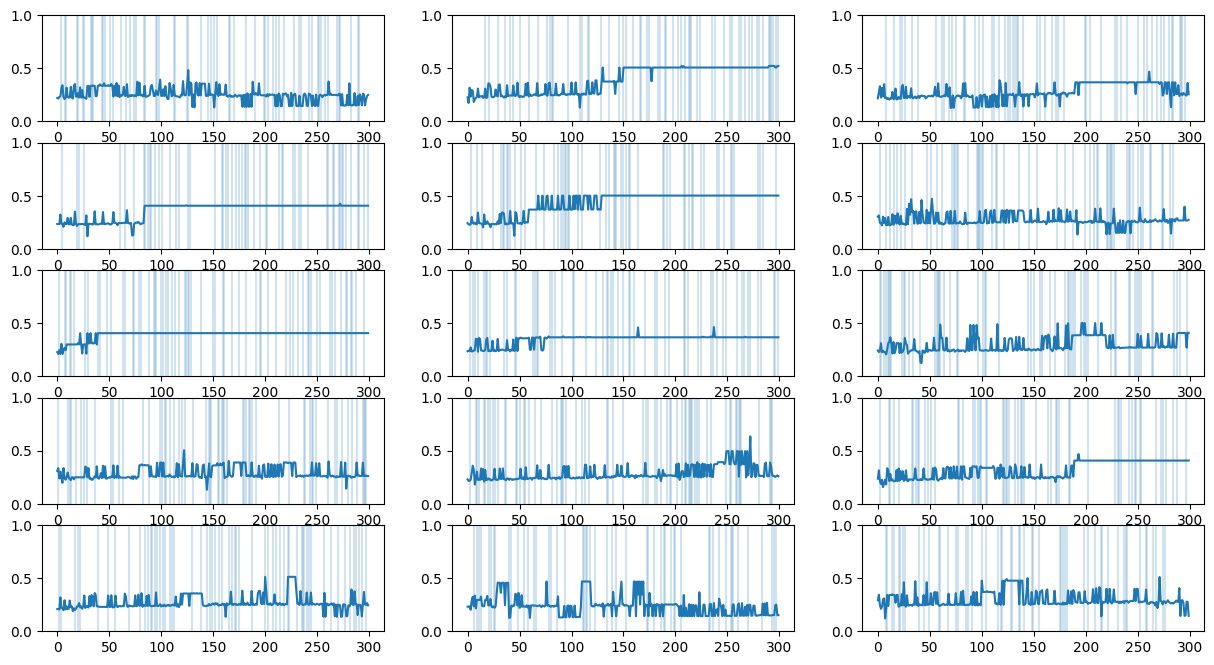

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize = (15, 8))

ax[0, 0].plot(globe['island0']['max_fit'])
[ax[0, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island0']['migration'][idx] is True else 0 for idx in range(len(globe['island0']['migration']))] if element != 0]]
ax[0, 0].set_ylim(0, 1)

ax[0, 1].plot(globe['island1']['max_fit'])
[ax[0, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island1']['migration'][idx] is True else 0 for idx in range(len(globe['island1']['migration']))] if element != 0]]
ax[0, 1].set_ylim(0, 1)

ax[0, 2].plot(globe['island2']['max_fit'])
[ax[0, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island2']['migration'][idx] is True else 0 for idx in range(len(globe['island2']['migration']))] if element != 0]]
ax[0, 2].set_ylim(0, 1)

ax[1, 0].plot(globe['island3']['max_fit'])
[ax[1, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island3']['migration'][idx] is True else 0 for idx in range(len(globe['island3']['migration']))] if element != 0]]
ax[1, 0].set_ylim(0, 1)

ax[1, 1].plot(globe['island4']['max_fit'])
[ax[1, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island4']['migration'][idx] is True else 0 for idx in range(len(globe['island4']['migration']))] if element != 0]]
ax[1, 1].set_ylim(0, 1)

ax[1, 2].plot(globe['island5']['max_fit'])
[ax[1, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island5']['migration'][idx] is True else 0 for idx in range(len(globe['island5']['migration']))] if element != 0]]
ax[1, 2].set_ylim(0, 1)

ax[2, 0].plot(globe['island6']['max_fit'])
[ax[2, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island6']['migration'][idx] is True else 0 for idx in range(len(globe['island6']['migration']))] if element != 0]]
ax[2, 0].set_ylim(0, 1)

ax[2, 1].plot(globe['island7']['max_fit'])
[ax[2, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island7']['migration'][idx] is True else 0 for idx in range(len(globe['island7']['migration']))] if element != 0]]
ax[2, 1].set_ylim(0, 1)

ax[2, 2].plot(globe['island8']['max_fit'])
[ax[2, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island8']['migration'][idx] is True else 0 for idx in range(len(globe['island8']['migration']))] if element != 0]]
ax[2, 2].set_ylim(0, 1)

ax[3, 0].plot(globe['island9']['max_fit'])
[ax[3, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island9']['migration'][idx] is True else 0 for idx in range(len(globe['island9']['migration']))] if element != 0]]
ax[3, 0].set_ylim(0, 1)

ax[3, 1].plot(globe['island10']['max_fit'])
[ax[3, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island10']['migration'][idx] is True else 0 for idx in range(len(globe['island10']['migration']))] if element != 0]]
ax[3, 1].set_ylim(0, 1)

ax[3, 2].plot(globe['island11']['max_fit'])
[ax[3, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island11']['migration'][idx] is True else 0 for idx in range(len(globe['island11']['migration']))] if element != 0]]
ax[3, 2].set_ylim(0, 1)

ax[4, 0].plot(globe['island12']['max_fit'])
[ax[4, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island12']['migration'][idx] is True else 0 for idx in range(len(globe['island12']['migration']))] if element != 0]]
ax[4, 0].set_ylim(0, 1)

ax[4, 1].plot(globe['island13']['max_fit'])
[ax[4, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island13']['migration'][idx] is True else 0 for idx in range(len(globe['island13']['migration']))] if element != 0]]
ax[4, 1].set_ylim(0, 1)

ax[4, 2].plot(globe['island14']['max_fit'])
[ax[4, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island14']['migration'][idx] is True else 0 for idx in range(len(globe['island14']['migration']))] if element != 0]]
_ = ax[4, 2].set_ylim(0, 1)


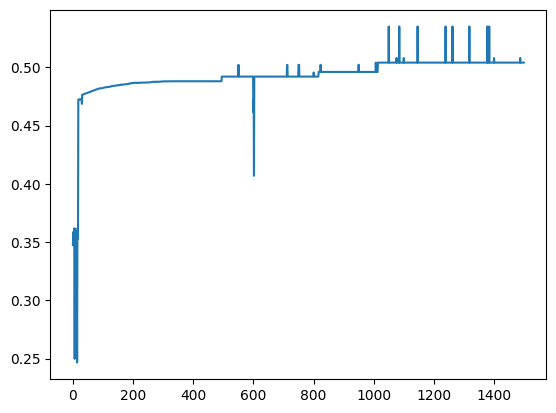

In [7]:
plt.plot(dubai['max_fit'])

##### `make_problem(10)`

- POP_SIZE = 30          
- N_OFFSPRINGS = 60      
- N_GENERATIONS = 2000    
- TOP_K = 15              
- EPOCH = 5             
- N_CHAMPIONS = 4        
- SIZE = 1000             
- P_MUTATION = 0.2        
- N_ISLANDS = 40
- N_MIGRANTS = 4
- SIZE_VALHALLA = 3 * N_CHAMPIONS
- P_MIGRATION = 0.2
- P_COMPLETE_MUTATION = 0.2
- COS = False
- GEN_TO_HOLIDAY = 10
- MIGRANTS_TO_HOLIDAY = 5
- HOLIDAY_DAYS = 50
- EPOCH_DUBAI = 20
- N_CHAMPIONS_DUBAI = 3
- SIZE_VALHALLA_DUBAI = 5 * N_CHAMPIONS_DUBAI

In [ ]:
# 50% with the configuration of problem 5
POP_SIZE = 30                       # Number of parents
N_OFFSPRINGS = 60                  # Number of children
N_GENERATIONS = 100                # Number of generations
TOP_K = 15                          # Number of parents from which generating the offsprings
EPOCH = 5                           # Number of generation to reintroduce all the champions
N_CHAMPIONS = 4                     # Number of champions that will be picked and sent each time to the population randomly
SIZE = 1000                         # Size of the genome
P_MUTATION = 0.2                    # Probability of a mutation        
N_ISLANDS = 40                      # Number of different populations
N_MIGRANTS = 4                      # Number of migrants from one island
SIZE_VALHALLA = 3 * N_CHAMPIONS     # Maximum number of champions
P_MIGRATION = 0.2
P_COMPLETE_MUTATION = 0.2
COS = False
GEN_TO_HOLIDAY = 10
MIGRANTS_TO_HOLIDAY = 5
HOLIDAY_DAYS = 50
EPOCH_DUBAI = 20
N_CHAMPIONS_DUBAI = 3
SIZE_VALHALLA_DUBAI = 3 * N_CHAMPIONS_DUBAI

fitness = lab9_lib.make_problem(10)

globe = {f'island{k}' : {'pop' : []} for k in range(N_ISLANDS)}
family_tree = {}

for n in range(N_ISLANDS):
    for _ in range(POP_SIZE):
        individual = choices([0, 1], k=SIZE, weights=choices(([0.6, 0.4], [0.5, 0.5], [0.4, 0.6]), k = 1)[0])
        globe[f'island{n}']['pop'].append(individual)

In [ ]:
def mutate_bit(individual : list) -> list:
    if random() < P_MUTATION:    
        idx = np.random.randint(0, len(individual))
        mutated_individual = copy.deepcopy(individual)
        mutated_individual[idx] = 1 - mutated_individual[idx]
        return mutated_individual
    return individual


def get_distribution(survived : list) -> list:
    return (np.sum(survived, axis = 0) / (np.ones(shape = len(survived[0])) * POP_SIZE)).reshape(1, -1)


def compute_cosine(individual : list, distr : list) -> list:
    return cosine_similarity(np.array(individual).reshape(1, -1), distr.reshape(1, -1))


def compute_manhattan(individual : list, distr : list) -> list:
    return np.sum(np.abs(np.array(individual) - distr))


def mutate_all(individual : list) -> list:
    mutated_individual = copy.deepcopy(individual)
    for idx in range(len(mutated_individual)):
        if random() < P_COMPLETE_MUTATION:
            mutated_individual[idx] = 1 - mutated_individual[idx]
    return mutated_individual


def roulette_selection(top_k : int, individuals : list, fitness : list) -> list:
    parents = choices(individuals, weights=np.array(fitness)/sum(fitness), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def roulette_selection_memoization(top_k : int, individuals : list, family_tree, dubai : bool = False) -> list:
    fitness_list = []
    for individual in individuals:
         
        if tuple(individual) not in family_tree.keys():
            family_tree[tuple(individual)] = fitness(individual)
            fitness_list.append(family_tree[tuple(individual)])
        else:
            fitness_list.append(family_tree[tuple(individual)])
        
    parents = choices(individuals, weights=np.array(fitness_list)/sum(fitness_list), k=top_k)
    if dubai:
        return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=300)
    
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def one_cut_xover(couple : tuple) -> list:
    idx = np.random.randint(1, len(couple[0]) - 1)
    return np.concatenate((couple[0][:idx], couple[1][idx:]))

def uniform_xover(couple : tuple) -> list:
    child = np.ndarray(shape = len(couple[0]), dtype=np.int16)
    for i in range(len(couple[0])):
        gene_giver = choice([couple[0], couple[1]])
        child[i] = int(gene_giver[i])
    return child

def n_cuts_xover(couple : tuple) -> list:
    if random() < 0.7:
        idx_1 = np.random.randint(1, len(couple[0]) - 2)
        idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
        return np.concatenate((couple[0][idx_1:idx_2], couple[1][:idx_1], couple[0][idx_2:]))
    else:
        idx_1 = np.random.randint(1, len(couple[0]) / 2)
        idx_3 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
        idx_2 = np.random.randint(idx_1, idx_3)
        return np.concatenate((couple[1][:idx_1], couple[0][idx_1:idx_2], couple[1][idx_2:idx_3], couple[0][idx_3:]))

def random_xover(couple : tuple) -> list:
    flag = random()
    if flag < 0.33:
        return one_cut_xover(couple)
    elif 0.33 <= flag < 0.66:
        return uniform_xover(couple)
    elif 0.66 <= flag < 1:
        return n_cuts_xover(couple)

In [ ]:
dubai = {}
dubai['max_fit'] = []
dubai['avg_fit'] = []
dubai['valhalla'] = np.zeros(shape = (SIZE_VALHALLA_DUBAI, SIZE), dtype=np.int16)
dubai['fit_god'] = 0
dubai['survived'] = np.zeros(shape = 1000)

for island in globe.keys():
    family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['pop']})
    globe[island]['parents'] = roulette_selection_memoization(TOP_K, globe[island]['pop'], family_tree)
    globe[island]['valhalla'] = np.zeros(shape = (SIZE_VALHALLA, SIZE), dtype=np.int16)
    globe[island]['max_fit'] = []
    globe[island]['avg_fit'] = []
    globe[island]['fit_god'] = 0
    globe[island]['migration'] = []


terminator = False
gen = 0
end = 0
end_dubai = 0
pbar = tqdm(total = N_GENERATIONS)

while gen < N_GENERATIONS and not terminator:
    
    for island in globe.keys():

        if random() < P_MIGRATION and len(globe.keys()) > 1:
             
             if np.array(['survived' in globe[isl].keys() for isl in globe.keys()]).all():
                island_distr = {isl : get_distribution(globe[isl]['survived']) for isl in globe.keys()}
    
                if COS:
                    island_cos = {isl : cosine_similarity(island_distr[isl], get_distribution(globe[island]['survived'])) for isl in island_distr.keys()}
                    unnormalized_weights = 1 / np.array(list(island_cos.values()))
                    weights = unnormalized_weights / sum(unnormalized_weights)
                else:
                    island_manhattan = {isl : compute_manhattan(island_distr[isl], get_distribution(globe[island]['survived'])) for isl in island_distr.keys()}
                    weights = (np.array(list(island_manhattan.values())) ** 2) / (sum(np.array(list(island_manhattan.values())) ** 2))
                
                       
                home = choices([isl for isl in globe.keys()], weights=weights)[0]
                # home = choice([isl for isl in globe.keys() if isl != island])
                if 'valhalla' in globe[home].keys() and len(globe[home]['valhalla']) != 0:
                    migrant = list(map(list, choices(globe[home]['valhalla'], k = N_MIGRANTS)))
                    migrant_couple = [(migrant[i], globe[island]['parents'][rnd][0]) for i, rnd in zip(range(len(migrant)), np.random.randint(0, len(globe[island]['parents']), size = len(migrant)))]
                    globe[island]['parents'] = globe[island]['parents'] + migrant_couple
                    globe[island]['migration'].append(True)
        else:
            globe[island]['migration'].append(False)

        recombinated_offsprings = list(map(random_xover, globe[island]['parents']))
        globe[island]['mutated_offsprings'] = np.array(list(map(mutate_bit, recombinated_offsprings)))
        if random() < 0.1:
            zombie = []
            sur = globe[island]['mutated_offsprings']
            for s in sur:
                if random() < 0.2:
                    zombie.append(mutate_all(s))
            if len(zombie) != 0:
                globe[island]['mutated_offsprings'] = np.vstack((globe[island]['mutated_offsprings'], zombie))
                                   
        fitness_list = []

        for off in globe[island]['mutated_offsprings']:
            if tuple(off) not in family_tree.keys():
                family_tree[tuple(off)] = fitness(tuple(off))
            fitness_list.append(family_tree[tuple(off)])

        globe[island]['fit'] = np.array(fitness_list)
        globe[island]['survived'] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-POP_SIZE:]]
        globe[island]['max_fit'].append(max(globe[island]['fit']))
        god = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-1]]
        fitness_god = fitness(god) if tuple(god) not in family_tree.keys() else family_tree[tuple(god)]
        if fitness_god >= globe[island]['fit_god']:
            globe[island]['god'] = god
            globe[island]['fit_god'] = fitness_god
        
        globe[island]['avg_fit'].append(np.mean(globe[island]['fit']))
        
        if globe[island]['fit_god'] >= 0.55:
            terminator = True
            break
    
        if gen % 5 == 0 and gen != 0:
            if end == 0 or end == SIZE_VALHALLA:
                count = 0
            start = count
            end = start + N_CHAMPIONS
            count += N_CHAMPIONS
            globe[island]['valhalla'][start:end, :] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-N_CHAMPIONS:]]
        
        if gen % EPOCH == 0 and gen != 0:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], globe[island]['valhalla']))

        if random() < 0.5  and gen != 0:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], choices(globe[island]['valhalla'], k = N_CHAMPIONS)))
        
        if random() < 0.1:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], globe[island]['god']))

        family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['survived']})

    gen += 1
    if gen % GEN_TO_HOLIDAY == 0:
            tmp = [choices(globe[isl]['survived'], k = MIGRANTS_TO_HOLIDAY) for isl in globe.keys()]
            tmp_2 = [globe[isl]['god'] for isl in globe.keys()]
            for i, b in zip(tmp, tmp_2):
                for a in i:
                    dubai['survived'] = np.vstack((dubai['survived'], np.array(a)))
                dubai['survived'] = np.vstack((dubai['survived'], np.array(b)))
            dubai['parents'] = roulette_selection_memoization(30, dubai['survived'], family_tree, True)

            for _ in range(HOLIDAY_DAYS):
                recombinated_offsprings = list(map(random_xover, dubai['parents']))
                dubai['mutated_offsprings'] = np.array(list(map(mutate_bit, recombinated_offsprings)))
                
                if random() < 0.1:
                    zombie_dubai = []
                    sur_dubai = dubai['mutated_offsprings']
                    for s in sur_dubai:
                        if random() < 0.2:
                            zombie_dubai.append(mutate_all(s))
                    if len(zombie_dubai) != 0:
                        dubai['mutated_offsprings'] = np.vstack((dubai['mutated_offsprings'], zombie_dubai))

                fitness_list = []

                for off in dubai['mutated_offsprings']:
                    if tuple(off) not in family_tree.keys():
                        family_tree[tuple(off)] = fitness(tuple(off))
                    fitness_list.append(family_tree[tuple(off)])
                dubai['fit'] = np.array(fitness_list)
                dubai['survived'] = dubai['mutated_offsprings'][np.argsort(dubai['fit'])[-50:]]
                dubai['max_fit'].append(max(dubai['fit']))
                god = dubai['mutated_offsprings'][np.argsort(dubai['fit'])[-1]]
                fitness_god = fitness(god) if tuple(god) not in family_tree.keys() else family_tree[tuple(god)]
                if fitness_god >= dubai['fit_god']:
                    dubai['god'] = god
                    dubai['fit_god'] = fitness_god

                dubai['avg_fit'].append(np.mean(dubai['fit']))
                family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in dubai['survived']})

                if _ % 10 == 0 and _ != 0:
                    if end_dubai == 0 or end_dubai == SIZE_VALHALLA_DUBAI:
                        count_dubai = 0
                    start_dubai = count_dubai
                    end_dubai = start_dubai + N_CHAMPIONS_DUBAI
                    count_dubai += N_CHAMPIONS_DUBAI
                    dubai['valhalla'][start_dubai:end_dubai, :] = dubai['mutated_offsprings'][np.argsort(dubai['fit'])[-N_CHAMPIONS_DUBAI:]]
                
                if _ % EPOCH_DUBAI == 0 and _ != 0:
                    dubai['survived'] = np.vstack((dubai['survived'], dubai['valhalla']))

                if random() < 0.5  and gen != 0:
                    dubai['survived'] = np.vstack((dubai['survived'], choices(dubai['valhalla'], k = N_CHAMPIONS_DUBAI)))
                
                if random() < 0.2:
                    dubai['survived'] = np.vstack((dubai['survived'], dubai['god']))
                
                dubai['parents'] = roulette_selection_memoization(30, dubai['survived'], family_tree, True)
            
                family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in dubai['survived']})
            
            # for k in globe.keys():
            #     if random() < 0.1:
            #         globe[k]['survived'] = np.vstack((globe[k]['survived'], choices(dubai['valhalla'], k = 2)))
            #         globe[k]['survived'] = np.vstack((globe[k]['survived'], dubai['god']))
   
            for kk in globe.keys():
                globe[kk]['parents'] = roulette_selection_memoization(TOP_K, globe[kk]['survived'], family_tree)
    
    pbar.update(1)

pbar.close()

fit_island = {globe[i]['fit_god'] : i for i in globe.keys()}
fit_island[dubai['fit_god']] = 'dubai'
print(f'Fitness calls: {fitness.calls}\nMax fitness: {max(fit_island.keys())} ({fit_island[max(fit_island.keys())]})')

100%|██████████| 100/100 [02:56<00:00,  1.76s/it]

Fitness calls: 330498
Max fitness: 0.427242 (island26)


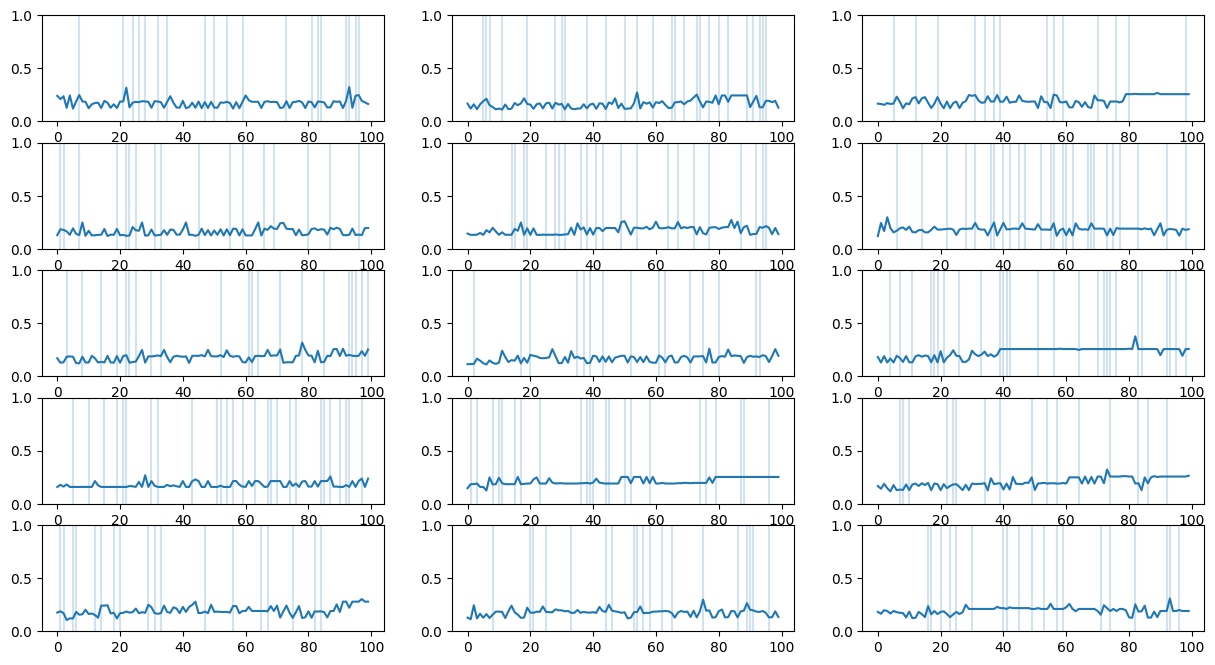

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize = (15, 8))

ax[0, 0].plot(globe['island0']['max_fit'])
[ax[0, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island0']['migration'][idx] is True else 0 for idx in range(len(globe['island0']['migration']))] if element != 0]]
ax[0, 0].set_ylim(0, 1)

ax[0, 1].plot(globe['island1']['max_fit'])
[ax[0, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island1']['migration'][idx] is True else 0 for idx in range(len(globe['island1']['migration']))] if element != 0]]
ax[0, 1].set_ylim(0, 1)

ax[0, 2].plot(globe['island2']['max_fit'])
[ax[0, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island2']['migration'][idx] is True else 0 for idx in range(len(globe['island2']['migration']))] if element != 0]]
ax[0, 2].set_ylim(0, 1)

ax[1, 0].plot(globe['island3']['max_fit'])
[ax[1, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island3']['migration'][idx] is True else 0 for idx in range(len(globe['island3']['migration']))] if element != 0]]
ax[1, 0].set_ylim(0, 1)

ax[1, 1].plot(globe['island4']['max_fit'])
[ax[1, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island4']['migration'][idx] is True else 0 for idx in range(len(globe['island4']['migration']))] if element != 0]]
ax[1, 1].set_ylim(0, 1)

ax[1, 2].plot(globe['island5']['max_fit'])
[ax[1, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island5']['migration'][idx] is True else 0 for idx in range(len(globe['island5']['migration']))] if element != 0]]
ax[1, 2].set_ylim(0, 1)

ax[2, 0].plot(globe['island6']['max_fit'])
[ax[2, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island6']['migration'][idx] is True else 0 for idx in range(len(globe['island6']['migration']))] if element != 0]]
ax[2, 0].set_ylim(0, 1)

ax[2, 1].plot(globe['island7']['max_fit'])
[ax[2, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island7']['migration'][idx] is True else 0 for idx in range(len(globe['island7']['migration']))] if element != 0]]
ax[2, 1].set_ylim(0, 1)

ax[2, 2].plot(globe['island8']['max_fit'])
[ax[2, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island8']['migration'][idx] is True else 0 for idx in range(len(globe['island8']['migration']))] if element != 0]]
ax[2, 2].set_ylim(0, 1)

ax[3, 0].plot(globe['island9']['max_fit'])
[ax[3, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island9']['migration'][idx] is True else 0 for idx in range(len(globe['island9']['migration']))] if element != 0]]
ax[3, 0].set_ylim(0, 1)

ax[3, 1].plot(globe['island10']['max_fit'])
[ax[3, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island10']['migration'][idx] is True else 0 for idx in range(len(globe['island10']['migration']))] if element != 0]]
ax[3, 1].set_ylim(0, 1)

ax[3, 2].plot(globe['island11']['max_fit'])
[ax[3, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island11']['migration'][idx] is True else 0 for idx in range(len(globe['island11']['migration']))] if element != 0]]
ax[3, 2].set_ylim(0, 1)

ax[4, 0].plot(globe['island12']['max_fit'])
[ax[4, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island12']['migration'][idx] is True else 0 for idx in range(len(globe['island12']['migration']))] if element != 0]]
ax[4, 0].set_ylim(0, 1)

ax[4, 1].plot(globe['island13']['max_fit'])
[ax[4, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island13']['migration'][idx] is True else 0 for idx in range(len(globe['island13']['migration']))] if element != 0]]
ax[4, 1].set_ylim(0, 1)

ax[4, 2].plot(globe['island14']['max_fit'])
[ax[4, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island14']['migration'][idx] is True else 0 for idx in range(len(globe['island14']['migration']))] if element != 0]]
_ = ax[4, 2].set_ylim(0, 1)


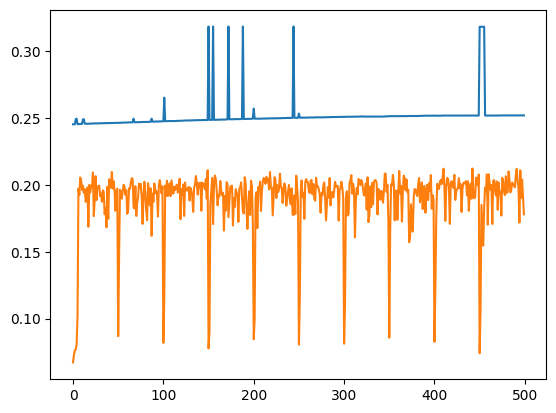

In [ ]:
plt.plot(dubai['max_fit'])
plt.plot(dubai['avg_fit'])

In [ ]:
max_f = []
for k in globe.keys():
    max_f.append(globe[k]['fit_god'])
# This number of calls is an upper bound, by stopping earlier we can drastically diminish it.
print(max(max_f), fitness.calls)

0.468911 374495


# Valhalla + Islands + Federation (Dependent Federation)

##### `make_problem(5)`

- POP_SIZE = 30          
- N_OFFSPRINGS = 60      
- N_GENERATIONS = 2000    
- TOP_K = 15              
- EPOCH = 5             
- N_CHAMPIONS = 4        
- SIZE = 1000             
- P_MUTATION = 0.2        
- N_ISLANDS = 40
- N_MIGRANTS = 4
- SIZE_VALHALLA = 3 * N_CHAMPIONS
- P_MIGRATION = 0.2
- P_COMPLETE_MUTATION = 0.2
- COS = False
- GEN_TO_HOLIDAY = 10
- MIGRANTS_TO_HOLIDAY = 5
- HOLIDAY_DAYS = 50
- EPOCH_DUBAI = 20
- N_CHAMPIONS_DUBAI = 3
- SIZE_VALHALLA_DUBAI = 5 * N_CHAMPIONS_DUBAI

In [2]:
# Reached 0.745 with more or less 300_000 calls with the following configuration!!!
POP_SIZE = 30                        # Number of parents
N_OFFSPRINGS = 60                   # Number of children
N_GENERATIONS = 150                # Number of generations
TOP_K = 15                           # Number of parents from which generating the offsprings
EPOCH = 5                           # Number of generation to reintroduce all the champions
N_CHAMPIONS = 4                     # Number of champions that will be picked and sent each time to the population randomly
SIZE = 1000                         # Size of the genome
P_MUTATION = 0.2                    # Probability of a mutation        
N_ISLANDS = 40                      # Number of different populations
N_MIGRANTS = 4                      # Number of migrants from one island
SIZE_VALHALLA = 3 * N_CHAMPIONS     # Maximum number of champions
P_MIGRATION = 0.2
P_COMPLETE_MUTATION = 0.2
COS = False
GEN_TO_HOLIDAY = 10
MIGRANTS_TO_HOLIDAY = 5
HOLIDAY_DAYS = 50
EPOCH_DUBAI = 20
N_CHAMPIONS_DUBAI = 3
SIZE_VALHALLA_DUBAI = 5 * N_CHAMPIONS_DUBAI

fitness = lab9_lib.make_problem(5)

globe = {f'island{k}' : {'pop' : []} for k in range(N_ISLANDS)}
family_tree = {}

for n in range(N_ISLANDS):
    for _ in range(POP_SIZE):
        individual = choices([0, 1], k=SIZE, weights=choices(([0.6, 0.4], [0.5, 0.5], [0.4, 0.6]), k = 1)[0])
        globe[f'island{n}']['pop'].append(individual)

In [3]:
def mutate_bit(individual : list) -> list:
    if random() < P_MUTATION:    
        idx = np.random.randint(0, len(individual))
        mutated_individual = copy.deepcopy(individual)
        mutated_individual[idx] = 1 - mutated_individual[idx]
        return mutated_individual
    return individual


def get_distribution(survived : list) -> list:
    return (np.sum(survived, axis = 0) / (np.ones(shape = len(survived[0])) * POP_SIZE)).reshape(1, -1)


def compute_cosine(individual : list, distr : list) -> list:
    return cosine_similarity(np.array(individual).reshape(1, -1), distr.reshape(1, -1))


def compute_manhattan(individual : list, distr : list) -> list:
    return np.sum(np.abs(np.array(individual) - distr))


def mutate_all(individual : list) -> list:
    mutated_individual = copy.deepcopy(individual)
    for idx in range(len(mutated_individual)):
        if random() < P_COMPLETE_MUTATION:
            mutated_individual[idx] = 1 - mutated_individual[idx]
    return mutated_individual


def roulette_selection(top_k : int, individuals : list, fitness : list) -> list:
    parents = choices(individuals, weights=np.array(fitness)/sum(fitness), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def roulette_selection_memoization(top_k : int, individuals : list, family_tree, dubai : bool = False) -> list:
    fitness_list = []
    for individual in individuals:
         
        if tuple(individual) not in family_tree.keys():
            family_tree[tuple(individual)] = fitness(individual)
            fitness_list.append(family_tree[tuple(individual)])
        else:
            fitness_list.append(family_tree[tuple(individual)])
        
    parents = choices(individuals, weights=np.array(fitness_list)/sum(fitness_list), k=top_k)
    if dubai:
        return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=300)
    
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def one_cut_xover(couple : tuple) -> list:
    idx = np.random.randint(1, len(couple[0]) - 1)
    return np.concatenate((couple[0][:idx], couple[1][idx:]))

def uniform_xover(couple : tuple) -> list:
    child = np.ndarray(shape = len(couple[0]), dtype=np.int16)
    for i in range(len(couple[0])):
        gene_giver = choice([couple[0], couple[1]])
        child[i] = int(gene_giver[i])
    return child

def n_cuts_xover(couple : tuple) -> list:
    if random() < 0.7:
        idx_1 = np.random.randint(1, len(couple[0]) - 2)
        idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
        return np.concatenate((couple[0][idx_1:idx_2], couple[1][:idx_1], couple[0][idx_2:]))
    else:
        idx_1 = np.random.randint(1, len(couple[0]) / 2)
        idx_3 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
        idx_2 = np.random.randint(idx_1, idx_3)
        return np.concatenate((couple[1][:idx_1], couple[0][idx_1:idx_2], couple[1][idx_2:idx_3], couple[0][idx_3:]))

def random_xover(couple : tuple) -> list:
    flag = random()
    if flag < 0.33:
        return one_cut_xover(couple)
    elif 0.33 <= flag < 0.66:
        return uniform_xover(couple)
    elif 0.66 <= flag < 1:
        return n_cuts_xover(couple)

In [4]:
dubai = {}
dubai['max_fit'] = []
dubai['avg_fit'] = []
dubai['valhalla'] = np.zeros(shape = (SIZE_VALHALLA_DUBAI, SIZE), dtype=np.int16)
dubai['fit_god'] = 0
dubai['survived'] = np.zeros(shape = 1000)

for island in globe.keys():
    family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['pop']})
    globe[island]['parents'] = roulette_selection_memoization(TOP_K, globe[island]['pop'], family_tree)
    globe[island]['valhalla'] = np.zeros(shape = (SIZE_VALHALLA, SIZE), dtype=np.int16)
    globe[island]['max_fit'] = []
    globe[island]['avg_fit'] = []
    globe[island]['fit_god'] = 0
    globe[island]['migration'] = []


terminator = False
gen = 0
end = 0
end_dubai = 0
pbar = tqdm(total = N_GENERATIONS)

while gen < N_GENERATIONS and not terminator:
    
    for island in globe.keys():

        if random() < P_MIGRATION and len(globe.keys()) > 1:
             
             if np.array(['survived' in globe[isl].keys() for isl in globe.keys()]).all():
                island_distr = {isl : get_distribution(globe[isl]['survived']) for isl in globe.keys()}
    
                if COS:
                    island_cos = {isl : cosine_similarity(island_distr[isl], get_distribution(globe[island]['survived'])) for isl in island_distr.keys()}
                    unnormalized_weights = 1 / np.array(list(island_cos.values()))
                    weights = unnormalized_weights / sum(unnormalized_weights)
                else:
                    island_manhattan = {isl : compute_manhattan(island_distr[isl], get_distribution(globe[island]['survived'])) for isl in island_distr.keys()}
                    weights = (np.array(list(island_manhattan.values())) ** 2) / (sum(np.array(list(island_manhattan.values())) ** 2))
                
                       
                home = choices([isl for isl in globe.keys()], weights=weights)[0]
                # home = choice([isl for isl in globe.keys() if isl != island])
                if 'valhalla' in globe[home].keys() and len(globe[home]['valhalla']) != 0:
                    migrant = list(map(list, choices(globe[home]['valhalla'], k = N_MIGRANTS)))
                    migrant_couple = [(migrant[i], globe[island]['parents'][rnd][0]) for i, rnd in zip(range(len(migrant)), np.random.randint(0, len(globe[island]['parents']), size = len(migrant)))]
                    globe[island]['parents'] = globe[island]['parents'] + migrant_couple
                    globe[island]['migration'].append(True)
        else:
            globe[island]['migration'].append(False)

        recombinated_offsprings = list(map(random_xover, globe[island]['parents']))
        globe[island]['mutated_offsprings'] = np.array(list(map(mutate_bit, recombinated_offsprings)))
        if random() < 0.1:
            zombie = []
            sur = globe[island]['mutated_offsprings']
            for s in sur:
                if random() < 0.2:
                    zombie.append(mutate_all(s))
            if len(zombie) != 0:
                globe[island]['mutated_offsprings'] = np.vstack((globe[island]['mutated_offsprings'], zombie))
                                   
        fitness_list = []

        for off in globe[island]['mutated_offsprings']:
            if tuple(off) not in family_tree.keys():
                family_tree[tuple(off)] = fitness(tuple(off))
            fitness_list.append(family_tree[tuple(off)])

        globe[island]['fit'] = np.array(fitness_list)
        globe[island]['survived'] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-POP_SIZE:]]
        globe[island]['max_fit'].append(max(globe[island]['fit']))
        god = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-1]]
        fitness_god = fitness(god) if tuple(god) not in family_tree.keys() else family_tree[tuple(god)]
        if fitness_god >= globe[island]['fit_god']:
            globe[island]['god'] = god
            globe[island]['fit_god'] = fitness_god
        
        globe[island]['avg_fit'].append(np.mean(globe[island]['fit']))
        
        if globe[island]['fit_god'] >= 0.70:
            terminator = True
            break
    
        if gen % 5 == 0 and gen != 0:
            if end == 0 or end == SIZE_VALHALLA:
                count = 0
            start = count
            end = start + N_CHAMPIONS
            count += N_CHAMPIONS
            globe[island]['valhalla'][start:end, :] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-N_CHAMPIONS:]]
        
        if gen % EPOCH == 0 and gen != 0:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], globe[island]['valhalla']))

        if random() < 0.5  and gen != 0:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], choices(globe[island]['valhalla'], k = N_CHAMPIONS)))
        
        if random() < 0.1:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], globe[island]['god']))

        family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['survived']})

    gen += 1
    if gen % GEN_TO_HOLIDAY == 0:
            tmp = [choices(globe[isl]['survived'], k = MIGRANTS_TO_HOLIDAY) for isl in globe.keys()]
            tmp_2 = [globe[isl]['god'] for isl in globe.keys()]
            for i, b in zip(tmp, tmp_2):
                for a in i:
                    dubai['survived'] = np.vstack((dubai['survived'], np.array(a)))
                dubai['survived'] = np.vstack((dubai['survived'], np.array(b)))
            dubai['parents'] = roulette_selection_memoization(30, dubai['survived'], family_tree, True)

            for _ in range(HOLIDAY_DAYS):
                recombinated_offsprings = list(map(random_xover, dubai['parents']))
                dubai['mutated_offsprings'] = np.array(list(map(mutate_bit, recombinated_offsprings)))
                
                if random() < 0.1:
                    zombie_dubai = []
                    sur_dubai = dubai['mutated_offsprings']
                    for s in sur_dubai:
                        if random() < 0.2:
                            zombie_dubai.append(mutate_all(s))
                    if len(zombie_dubai) != 0:
                        dubai['mutated_offsprings'] = np.vstack((dubai['mutated_offsprings'], zombie_dubai))

                fitness_list = []

                for off in dubai['mutated_offsprings']:
                    if tuple(off) not in family_tree.keys():
                        family_tree[tuple(off)] = fitness(tuple(off))
                    fitness_list.append(family_tree[tuple(off)])
                dubai['fit'] = np.array(fitness_list)
                dubai['survived'] = dubai['mutated_offsprings'][np.argsort(dubai['fit'])[-50:]]
                dubai['max_fit'].append(max(dubai['fit']))
                god = dubai['mutated_offsprings'][np.argsort(dubai['fit'])[-1]]
                fitness_god = fitness(god) if tuple(god) not in family_tree.keys() else family_tree[tuple(god)]
                if fitness_god >= dubai['fit_god']:
                    dubai['god'] = god
                    dubai['fit_god'] = fitness_god

                dubai['avg_fit'].append(np.mean(dubai['fit']))
                family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in dubai['survived']})

                if _ % 10 == 0 and _ != 0:
                    if end_dubai == 0 or end_dubai == SIZE_VALHALLA_DUBAI:
                        count_dubai = 0
                    start_dubai = count_dubai
                    end_dubai = start_dubai + N_CHAMPIONS_DUBAI
                    count_dubai += N_CHAMPIONS_DUBAI
                    dubai['valhalla'][start_dubai:end_dubai, :] = dubai['mutated_offsprings'][np.argsort(dubai['fit'])[-N_CHAMPIONS_DUBAI:]]
                
                if _ % EPOCH_DUBAI == 0 and _ != 0:
                    dubai['survived'] = np.vstack((dubai['survived'], dubai['valhalla']))

                if random() < 0.5  and gen != 0:
                    dubai['survived'] = np.vstack((dubai['survived'], choices(dubai['valhalla'], k = N_CHAMPIONS_DUBAI)))
                
                if random() < 0.2:
                    dubai['survived'] = np.vstack((dubai['survived'], dubai['god']))
                
                dubai['parents'] = roulette_selection_memoization(30, dubai['survived'], family_tree, True)
            
                family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in dubai['survived']})
            
            for k in globe.keys():
                if random() < 0.1:
                    globe[k]['survived'] = np.vstack((globe[k]['survived'], choices(dubai['valhalla'], k = 2)))
                    globe[k]['survived'] = np.vstack((globe[k]['survived'], dubai['god']))
   
            for kk in globe.keys():
                globe[kk]['parents'] = roulette_selection_memoization(TOP_K, globe[kk]['survived'], family_tree)
    
    pbar.update(1)

pbar.close()

fit_island = {globe[i]['fit_god'] : i for i in globe.keys()}
fit_island[dubai['fit_god']] = 'dubai'
print(f'Fitness calls: {fitness.calls}\nMax fitness: {max(fit_island.keys())} ({fit_island[max(fit_island.keys())]})')

100%|██████████| 150/150 [04:14<00:00,  1.69s/it]

Fitness calls: 443099
Max fitness: 0.5165 (island10)


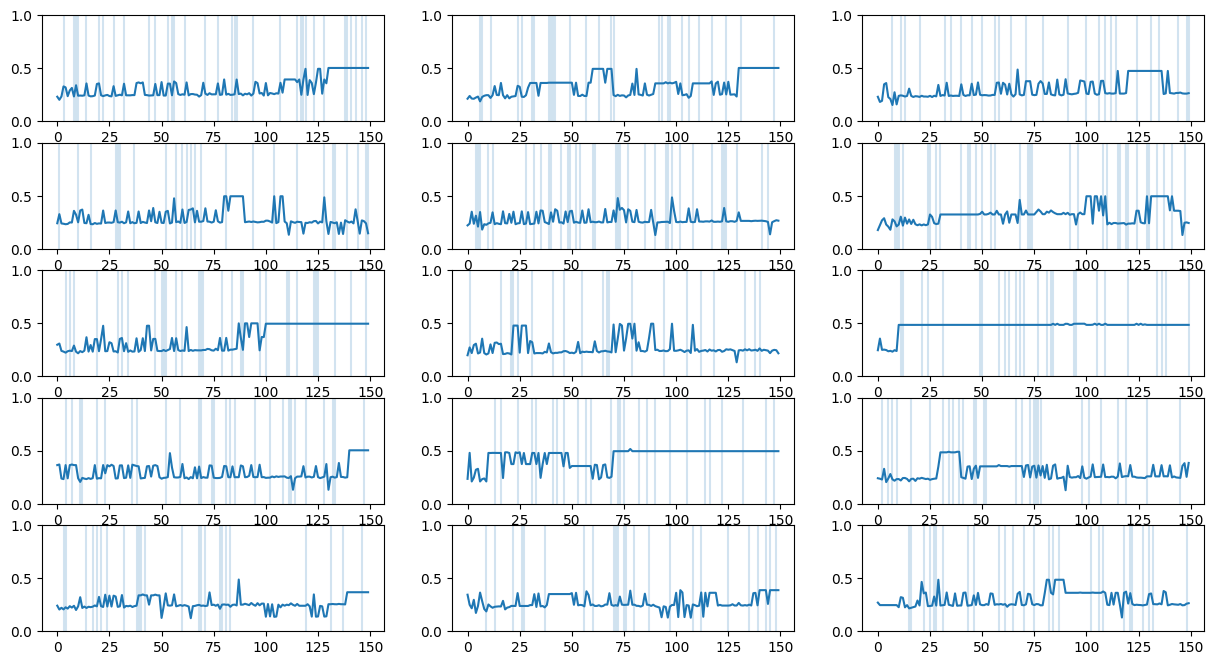

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize = (15, 8))

ax[0, 0].plot(globe['island0']['max_fit'])
[ax[0, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island0']['migration'][idx] is True else 0 for idx in range(len(globe['island0']['migration']))] if element != 0]]
ax[0, 0].set_ylim(0, 1)

ax[0, 1].plot(globe['island1']['max_fit'])
[ax[0, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island1']['migration'][idx] is True else 0 for idx in range(len(globe['island1']['migration']))] if element != 0]]
ax[0, 1].set_ylim(0, 1)

ax[0, 2].plot(globe['island2']['max_fit'])
[ax[0, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island2']['migration'][idx] is True else 0 for idx in range(len(globe['island2']['migration']))] if element != 0]]
ax[0, 2].set_ylim(0, 1)

ax[1, 0].plot(globe['island3']['max_fit'])
[ax[1, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island3']['migration'][idx] is True else 0 for idx in range(len(globe['island3']['migration']))] if element != 0]]
ax[1, 0].set_ylim(0, 1)

ax[1, 1].plot(globe['island4']['max_fit'])
[ax[1, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island4']['migration'][idx] is True else 0 for idx in range(len(globe['island4']['migration']))] if element != 0]]
ax[1, 1].set_ylim(0, 1)

ax[1, 2].plot(globe['island5']['max_fit'])
[ax[1, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island5']['migration'][idx] is True else 0 for idx in range(len(globe['island5']['migration']))] if element != 0]]
ax[1, 2].set_ylim(0, 1)

ax[2, 0].plot(globe['island6']['max_fit'])
[ax[2, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island6']['migration'][idx] is True else 0 for idx in range(len(globe['island6']['migration']))] if element != 0]]
ax[2, 0].set_ylim(0, 1)

ax[2, 1].plot(globe['island7']['max_fit'])
[ax[2, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island7']['migration'][idx] is True else 0 for idx in range(len(globe['island7']['migration']))] if element != 0]]
ax[2, 1].set_ylim(0, 1)

ax[2, 2].plot(globe['island8']['max_fit'])
[ax[2, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island8']['migration'][idx] is True else 0 for idx in range(len(globe['island8']['migration']))] if element != 0]]
ax[2, 2].set_ylim(0, 1)

ax[3, 0].plot(globe['island9']['max_fit'])
[ax[3, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island9']['migration'][idx] is True else 0 for idx in range(len(globe['island9']['migration']))] if element != 0]]
ax[3, 0].set_ylim(0, 1)

ax[3, 1].plot(globe['island10']['max_fit'])
[ax[3, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island10']['migration'][idx] is True else 0 for idx in range(len(globe['island10']['migration']))] if element != 0]]
ax[3, 1].set_ylim(0, 1)

ax[3, 2].plot(globe['island11']['max_fit'])
[ax[3, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island11']['migration'][idx] is True else 0 for idx in range(len(globe['island11']['migration']))] if element != 0]]
ax[3, 2].set_ylim(0, 1)

ax[4, 0].plot(globe['island12']['max_fit'])
[ax[4, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island12']['migration'][idx] is True else 0 for idx in range(len(globe['island12']['migration']))] if element != 0]]
ax[4, 0].set_ylim(0, 1)

ax[4, 1].plot(globe['island13']['max_fit'])
[ax[4, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island13']['migration'][idx] is True else 0 for idx in range(len(globe['island13']['migration']))] if element != 0]]
ax[4, 1].set_ylim(0, 1)

ax[4, 2].plot(globe['island14']['max_fit'])
[ax[4, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island14']['migration'][idx] is True else 0 for idx in range(len(globe['island14']['migration']))] if element != 0]]
_ = ax[4, 2].set_ylim(0, 1)


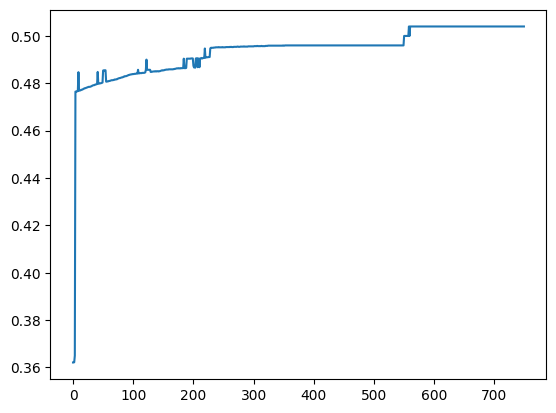

In [6]:
plt.plot(dubai['max_fit'])

##### `make_problem(10)`

- POP_SIZE = 30          
- N_OFFSPRINGS = 60      
- N_GENERATIONS = 2000    
- TOP_K = 15              
- EPOCH = 5             
- N_CHAMPIONS = 4        
- SIZE = 1000             
- P_MUTATION = 0.2        
- N_ISLANDS = 40
- N_MIGRANTS = 4
- SIZE_VALHALLA = 3 * N_CHAMPIONS
- P_MIGRATION = 0.2
- P_COMPLETE_MUTATION = 0.2
- COS = False
- GEN_TO_HOLIDAY = 10
- MIGRANTS_TO_HOLIDAY = 5
- HOLIDAY_DAYS = 50
- EPOCH_DUBAI = 20
- N_CHAMPIONS_DUBAI = 3
- SIZE_VALHALLA_DUBAI = 5 * N_CHAMPIONS_DUBAI

In [2]:
# 50% with the configuration of problem 5
POP_SIZE = 30                       # Number of parents
N_OFFSPRINGS = 60                  # Number of children
N_GENERATIONS = 100                # Number of generations
TOP_K = 15                          # Number of parents from which generating the offsprings
EPOCH = 5                           # Number of generation to reintroduce all the champions
N_CHAMPIONS = 4                     # Number of champions that will be picked and sent each time to the population randomly
SIZE = 1000                         # Size of the genome
P_MUTATION = 0.2                    # Probability of a mutation        
N_ISLANDS = 40                      # Number of different populations
N_MIGRANTS = 4                      # Number of migrants from one island
SIZE_VALHALLA = 3 * N_CHAMPIONS     # Maximum number of champions
P_MIGRATION = 0.2
P_COMPLETE_MUTATION = 0.2
COS = False
GEN_TO_HOLIDAY = 10
MIGRANTS_TO_HOLIDAY = 5
HOLIDAY_DAYS = 50
EPOCH_DUBAI = 20
N_CHAMPIONS_DUBAI = 3
SIZE_VALHALLA_DUBAI = 3 * N_CHAMPIONS_DUBAI

fitness = lab9_lib.make_problem(10)

globe = {f'island{k}' : {'pop' : []} for k in range(N_ISLANDS)}
family_tree = {}

for n in range(N_ISLANDS):
    for _ in range(POP_SIZE):
        individual = choices([0, 1], k=SIZE, weights=choices(([0.6, 0.4], [0.5, 0.5], [0.4, 0.6]), k = 1)[0])
        globe[f'island{n}']['pop'].append(individual)

In [3]:
def mutate_bit(individual : list) -> list:
    if random() < P_MUTATION:    
        idx = np.random.randint(0, len(individual))
        mutated_individual = copy.deepcopy(individual)
        mutated_individual[idx] = 1 - mutated_individual[idx]
        return mutated_individual
    return individual


def get_distribution(survived : list) -> list:
    return (np.sum(survived, axis = 0) / (np.ones(shape = len(survived[0])) * POP_SIZE)).reshape(1, -1)


def compute_cosine(individual : list, distr : list) -> list:
    return cosine_similarity(np.array(individual).reshape(1, -1), distr.reshape(1, -1))


def compute_manhattan(individual : list, distr : list) -> list:
    return np.sum(np.abs(np.array(individual) - distr))


def mutate_all(individual : list) -> list:
    mutated_individual = copy.deepcopy(individual)
    for idx in range(len(mutated_individual)):
        if random() < P_COMPLETE_MUTATION:
            mutated_individual[idx] = 1 - mutated_individual[idx]
    return mutated_individual


def roulette_selection(top_k : int, individuals : list, fitness : list) -> list:
    parents = choices(individuals, weights=np.array(fitness)/sum(fitness), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def roulette_selection_memoization(top_k : int, individuals : list, family_tree, dubai : bool = False) -> list:
    fitness_list = []
    for individual in individuals:
         
        if tuple(individual) not in family_tree.keys():
            family_tree[tuple(individual)] = fitness(individual)
            fitness_list.append(family_tree[tuple(individual)])
        else:
            fitness_list.append(family_tree[tuple(individual)])
        
    parents = choices(individuals, weights=np.array(fitness_list)/sum(fitness_list), k=top_k)
    if dubai:
        return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=300)
    
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def one_cut_xover(couple : tuple) -> list:
    idx = np.random.randint(1, len(couple[0]) - 1)
    return np.concatenate((couple[0][:idx], couple[1][idx:]))

def uniform_xover(couple : tuple) -> list:
    child = np.ndarray(shape = len(couple[0]), dtype=np.int16)
    for i in range(len(couple[0])):
        gene_giver = choice([couple[0], couple[1]])
        child[i] = int(gene_giver[i])
    return child

def n_cuts_xover(couple : tuple) -> list:
    if random() < 0.7:
        idx_1 = np.random.randint(1, len(couple[0]) - 2)
        idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
        return np.concatenate((couple[0][idx_1:idx_2], couple[1][:idx_1], couple[0][idx_2:]))
    else:
        idx_1 = np.random.randint(1, len(couple[0]) / 2)
        idx_3 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
        idx_2 = np.random.randint(idx_1, idx_3)
        return np.concatenate((couple[1][:idx_1], couple[0][idx_1:idx_2], couple[1][idx_2:idx_3], couple[0][idx_3:]))

def random_xover(couple : tuple) -> list:
    flag = random()
    if flag < 0.33:
        return one_cut_xover(couple)
    elif 0.33 <= flag < 0.66:
        return uniform_xover(couple)
    elif 0.66 <= flag < 1:
        return n_cuts_xover(couple)

In [4]:
dubai = {}
dubai['max_fit'] = []
dubai['avg_fit'] = []
dubai['valhalla'] = np.zeros(shape = (SIZE_VALHALLA_DUBAI, SIZE), dtype=np.int16)
dubai['fit_god'] = 0
dubai['survived'] = np.zeros(shape = 1000)

for island in globe.keys():
    family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['pop']})
    globe[island]['parents'] = roulette_selection_memoization(TOP_K, globe[island]['pop'], family_tree)
    globe[island]['valhalla'] = np.zeros(shape = (SIZE_VALHALLA, SIZE), dtype=np.int16)
    globe[island]['max_fit'] = []
    globe[island]['avg_fit'] = []
    globe[island]['fit_god'] = 0
    globe[island]['migration'] = []


terminator = False
gen = 0
end = 0
end_dubai = 0
pbar = tqdm(total = N_GENERATIONS)

while gen < N_GENERATIONS and not terminator:
    
    for island in globe.keys():

        if random() < P_MIGRATION and len(globe.keys()) > 1:
             
             if np.array(['survived' in globe[isl].keys() for isl in globe.keys()]).all():
                island_distr = {isl : get_distribution(globe[isl]['survived']) for isl in globe.keys()}
    
                if COS:
                    island_cos = {isl : cosine_similarity(island_distr[isl], get_distribution(globe[island]['survived'])) for isl in island_distr.keys()}
                    unnormalized_weights = 1 / np.array(list(island_cos.values()))
                    weights = unnormalized_weights / sum(unnormalized_weights)
                else:
                    island_manhattan = {isl : compute_manhattan(island_distr[isl], get_distribution(globe[island]['survived'])) for isl in island_distr.keys()}
                    weights = (np.array(list(island_manhattan.values())) ** 2) / (sum(np.array(list(island_manhattan.values())) ** 2))
                
                       
                home = choices([isl for isl in globe.keys()], weights=weights)[0]
                # home = choice([isl for isl in globe.keys() if isl != island])
                if 'valhalla' in globe[home].keys() and len(globe[home]['valhalla']) != 0:
                    migrant = list(map(list, choices(globe[home]['valhalla'], k = N_MIGRANTS)))
                    migrant_couple = [(migrant[i], globe[island]['parents'][rnd][0]) for i, rnd in zip(range(len(migrant)), np.random.randint(0, len(globe[island]['parents']), size = len(migrant)))]
                    globe[island]['parents'] = globe[island]['parents'] + migrant_couple
                    globe[island]['migration'].append(True)
        else:
            globe[island]['migration'].append(False)

        recombinated_offsprings = list(map(random_xover, globe[island]['parents']))
        globe[island]['mutated_offsprings'] = np.array(list(map(mutate_bit, recombinated_offsprings)))
        if random() < 0.1:
            zombie = []
            sur = globe[island]['mutated_offsprings']
            for s in sur:
                if random() < 0.2:
                    zombie.append(mutate_all(s))
            if len(zombie) != 0:
                globe[island]['mutated_offsprings'] = np.vstack((globe[island]['mutated_offsprings'], zombie))
                                   
        fitness_list = []

        for off in globe[island]['mutated_offsprings']:
            if tuple(off) not in family_tree.keys():
                family_tree[tuple(off)] = fitness(tuple(off))
            fitness_list.append(family_tree[tuple(off)])

        globe[island]['fit'] = np.array(fitness_list)
        globe[island]['survived'] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-POP_SIZE:]]
        globe[island]['max_fit'].append(max(globe[island]['fit']))
        god = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-1]]
        fitness_god = fitness(god) if tuple(god) not in family_tree.keys() else family_tree[tuple(god)]
        if fitness_god >= globe[island]['fit_god']:
            globe[island]['god'] = god
            globe[island]['fit_god'] = fitness_god
        
        globe[island]['avg_fit'].append(np.mean(globe[island]['fit']))
        
        if globe[island]['fit_god'] >= 0.55:
            terminator = True
            break
    
        if gen % 5 == 0 and gen != 0:
            if end == 0 or end == SIZE_VALHALLA:
                count = 0
            start = count
            end = start + N_CHAMPIONS
            count += N_CHAMPIONS
            globe[island]['valhalla'][start:end, :] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-N_CHAMPIONS:]]
        
        if gen % EPOCH == 0 and gen != 0:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], globe[island]['valhalla']))

        if random() < 0.5  and gen != 0:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], choices(globe[island]['valhalla'], k = N_CHAMPIONS)))
        
        if random() < 0.1:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], globe[island]['god']))

        family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['survived']})

    gen += 1
    if gen % GEN_TO_HOLIDAY == 0:
            tmp = [choices(globe[isl]['survived'], k = MIGRANTS_TO_HOLIDAY) for isl in globe.keys()]
            tmp_2 = [globe[isl]['god'] for isl in globe.keys()]
            for i, b in zip(tmp, tmp_2):
                for a in i:
                    dubai['survived'] = np.vstack((dubai['survived'], np.array(a)))
                dubai['survived'] = np.vstack((dubai['survived'], np.array(b)))
            dubai['parents'] = roulette_selection_memoization(30, dubai['survived'], family_tree, True)

            for _ in range(HOLIDAY_DAYS):
                recombinated_offsprings = list(map(random_xover, dubai['parents']))
                dubai['mutated_offsprings'] = np.array(list(map(mutate_bit, recombinated_offsprings)))
                
                if random() < 0.1:
                    zombie_dubai = []
                    sur_dubai = dubai['mutated_offsprings']
                    for s in sur_dubai:
                        if random() < 0.2:
                            zombie_dubai.append(mutate_all(s))
                    if len(zombie_dubai) != 0:
                        dubai['mutated_offsprings'] = np.vstack((dubai['mutated_offsprings'], zombie_dubai))

                fitness_list = []

                for off in dubai['mutated_offsprings']:
                    if tuple(off) not in family_tree.keys():
                        family_tree[tuple(off)] = fitness(tuple(off))
                    fitness_list.append(family_tree[tuple(off)])
                dubai['fit'] = np.array(fitness_list)
                dubai['survived'] = dubai['mutated_offsprings'][np.argsort(dubai['fit'])[-50:]]
                dubai['max_fit'].append(max(dubai['fit']))
                god = dubai['mutated_offsprings'][np.argsort(dubai['fit'])[-1]]
                fitness_god = fitness(god) if tuple(god) not in family_tree.keys() else family_tree[tuple(god)]
                if fitness_god >= dubai['fit_god']:
                    dubai['god'] = god
                    dubai['fit_god'] = fitness_god

                dubai['avg_fit'].append(np.mean(dubai['fit']))
                family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in dubai['survived']})

                if _ % 10 == 0 and _ != 0:
                    if end_dubai == 0 or end_dubai == SIZE_VALHALLA_DUBAI:
                        count_dubai = 0
                    start_dubai = count_dubai
                    end_dubai = start_dubai + N_CHAMPIONS_DUBAI
                    count_dubai += N_CHAMPIONS_DUBAI
                    dubai['valhalla'][start_dubai:end_dubai, :] = dubai['mutated_offsprings'][np.argsort(dubai['fit'])[-N_CHAMPIONS_DUBAI:]]
                
                if _ % EPOCH_DUBAI == 0 and _ != 0:
                    dubai['survived'] = np.vstack((dubai['survived'], dubai['valhalla']))

                if random() < 0.5  and gen != 0:
                    dubai['survived'] = np.vstack((dubai['survived'], choices(dubai['valhalla'], k = N_CHAMPIONS_DUBAI)))
                
                if random() < 0.2:
                    dubai['survived'] = np.vstack((dubai['survived'], dubai['god']))
                
                dubai['parents'] = roulette_selection_memoization(30, dubai['survived'], family_tree, True)
            
                family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in dubai['survived']})
            
            for k in globe.keys():
                if random() < 0.1:
                    globe[k]['survived'] = np.vstack((globe[k]['survived'], choices(dubai['valhalla'], k = 2)))
                    globe[k]['survived'] = np.vstack((globe[k]['survived'], dubai['god']))
   
            for kk in globe.keys():
                globe[kk]['parents'] = roulette_selection_memoization(TOP_K, globe[kk]['survived'], family_tree)
    
    pbar.update(1)

pbar.close()

fit_island = {globe[i]['fit_god'] : i for i in globe.keys()}
fit_island[dubai['fit_god']] = 'dubai'
print(f'Fitness calls: {fitness.calls}\nMax fitness: {max(fit_island.keys())} ({fit_island[max(fit_island.keys())]})')

100%|██████████| 100/100 [02:53<00:00,  1.73s/it]

Fitness calls: 310492
Max fitness: 0.37624470000000004 (island18)


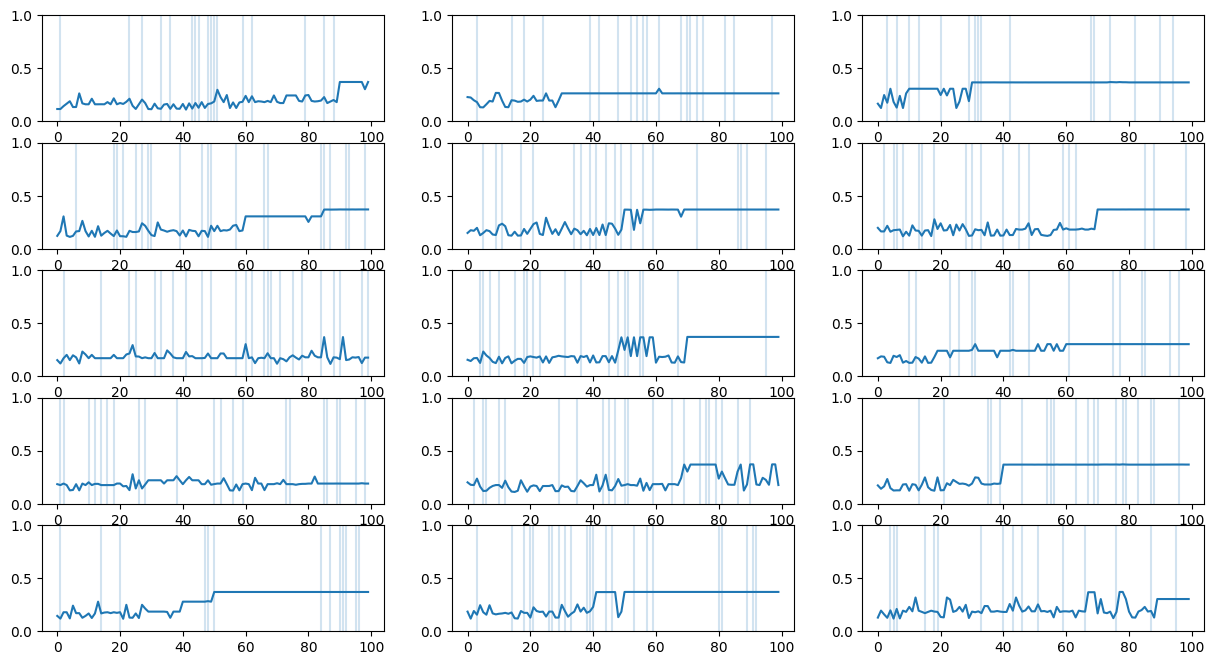

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize = (15, 8))

ax[0, 0].plot(globe['island0']['max_fit'])
[ax[0, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island0']['migration'][idx] is True else 0 for idx in range(len(globe['island0']['migration']))] if element != 0]]
ax[0, 0].set_ylim(0, 1)

ax[0, 1].plot(globe['island1']['max_fit'])
[ax[0, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island1']['migration'][idx] is True else 0 for idx in range(len(globe['island1']['migration']))] if element != 0]]
ax[0, 1].set_ylim(0, 1)

ax[0, 2].plot(globe['island2']['max_fit'])
[ax[0, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island2']['migration'][idx] is True else 0 for idx in range(len(globe['island2']['migration']))] if element != 0]]
ax[0, 2].set_ylim(0, 1)

ax[1, 0].plot(globe['island3']['max_fit'])
[ax[1, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island3']['migration'][idx] is True else 0 for idx in range(len(globe['island3']['migration']))] if element != 0]]
ax[1, 0].set_ylim(0, 1)

ax[1, 1].plot(globe['island4']['max_fit'])
[ax[1, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island4']['migration'][idx] is True else 0 for idx in range(len(globe['island4']['migration']))] if element != 0]]
ax[1, 1].set_ylim(0, 1)

ax[1, 2].plot(globe['island5']['max_fit'])
[ax[1, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island5']['migration'][idx] is True else 0 for idx in range(len(globe['island5']['migration']))] if element != 0]]
ax[1, 2].set_ylim(0, 1)

ax[2, 0].plot(globe['island6']['max_fit'])
[ax[2, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island6']['migration'][idx] is True else 0 for idx in range(len(globe['island6']['migration']))] if element != 0]]
ax[2, 0].set_ylim(0, 1)

ax[2, 1].plot(globe['island7']['max_fit'])
[ax[2, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island7']['migration'][idx] is True else 0 for idx in range(len(globe['island7']['migration']))] if element != 0]]
ax[2, 1].set_ylim(0, 1)

ax[2, 2].plot(globe['island8']['max_fit'])
[ax[2, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island8']['migration'][idx] is True else 0 for idx in range(len(globe['island8']['migration']))] if element != 0]]
ax[2, 2].set_ylim(0, 1)

ax[3, 0].plot(globe['island9']['max_fit'])
[ax[3, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island9']['migration'][idx] is True else 0 for idx in range(len(globe['island9']['migration']))] if element != 0]]
ax[3, 0].set_ylim(0, 1)

ax[3, 1].plot(globe['island10']['max_fit'])
[ax[3, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island10']['migration'][idx] is True else 0 for idx in range(len(globe['island10']['migration']))] if element != 0]]
ax[3, 1].set_ylim(0, 1)

ax[3, 2].plot(globe['island11']['max_fit'])
[ax[3, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island11']['migration'][idx] is True else 0 for idx in range(len(globe['island11']['migration']))] if element != 0]]
ax[3, 2].set_ylim(0, 1)

ax[4, 0].plot(globe['island12']['max_fit'])
[ax[4, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island12']['migration'][idx] is True else 0 for idx in range(len(globe['island12']['migration']))] if element != 0]]
ax[4, 0].set_ylim(0, 1)

ax[4, 1].plot(globe['island13']['max_fit'])
[ax[4, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island13']['migration'][idx] is True else 0 for idx in range(len(globe['island13']['migration']))] if element != 0]]
ax[4, 1].set_ylim(0, 1)

ax[4, 2].plot(globe['island14']['max_fit'])
[ax[4, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island14']['migration'][idx] is True else 0 for idx in range(len(globe['island14']['migration']))] if element != 0]]
_ = ax[4, 2].set_ylim(0, 1)


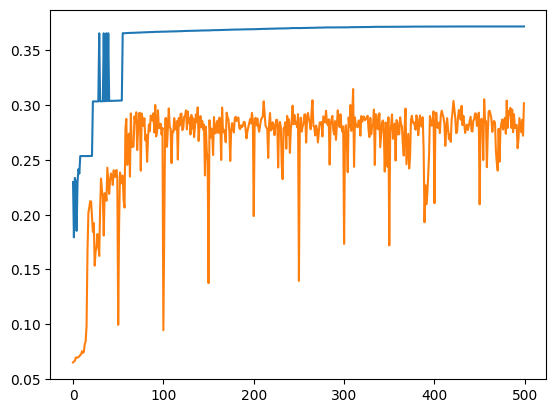

In [6]:
plt.plot(dubai['max_fit'])
plt.plot(dubai['avg_fit'])

In [ ]:
max_f = []
for k in globe.keys():
    max_f.append(globe[k]['fit_god'])
# This number of calls is an upper bound, by stopping earlier we can drastically diminish it.
print(max(max_f), fitness.calls)

0.468911 374495
